# Бриф 1. Агентство недвижимости

Ваша задача — разработать сервис для предсказания стоимости домов на основе истории предложений.

## Загружаем библиотеки

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

from collections import Counter
import os
import re
import ast
import json
import joblib
import numpy as np

import pickle

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.compose import TransformedTargetRegressor
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.model_selection import RandomizedSearchCV

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

import time


# Часть 1. Анализ и доработка данных.

## Загружаем исходные данные

In [17]:
data = pd.read_csv('./data/data.csv')

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103114 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226469 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

In [19]:
data.head()

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000"
3,for sale,NaN,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,NaN,NaN,14191809,"$2,395,000"
4,for sale,NaN,lot/land,1524 Kiscoe St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,NaN,NaN,861745,"$5,000"


- status - статус объявления.
- private pool - наличие бассейна.
- propertyType - тип недвижимости.
- street - улица.
- baths - количество ванных.
- homeFacts - характеристики дома.
- fireplace - наличие камина.
- city - город.
- schools - рейтинг ближайших школ.
- sqft - площадь.
- zipcode - почтовый индекс.
- beds - количество спален.
- state - штат.
- stories - количество этажей.
- mls-id - идентификатор в службе множественного размещения.
- PrivatePool - наличие бассейна.
- MlsId - идентификатор в службе множественного размещения.
- __target__ - Цена недвижимости (целевая переменная)

__Mlsid__ - это уникальный код, который используется для отслеживания данных о недвижимости при покупке или продаже. Его генерирует и управляет локальная или региональная организация MLS, которая функционирует как кооперативная база данных для брокеров.

Предположу, что на цену этот параметр не повлияет и удалю оба столбца.

In [20]:
data.drop(['mls-id', 'MlsId'], axis=1, inplace=True)

Добавлю свой идентификатор строк для удобства.

In [21]:
data['row_id'] = range(1, len(data) + 1)

Удалим явные дубликаты.

In [22]:
data.drop_duplicates(inplace=True)

Объединим два признака с бассейнами в 1. За основной возьмем _PrivatePool_ и дополним его информацией из признака _private pool_.

In [23]:
# Объединю private pool и PrivatePool
data['pool'] = data['PrivatePool'].combine_first(data['private pool'])
data['pool'] = data['pool'].fillna('no').str.lower().str.strip().eq('yes')

# Удалю старые признаки с бассейном
data.drop(['PrivatePool', 'private pool'], axis=1, inplace=True)

## Работаем с пропусками.

Напишем функцию для подсчета пропусков в признаках.

In [24]:
def show_missing_columns(df):
    missing = df.isnull().sum()
    missing = missing[missing > 0]

    if len(missing) == 0:
        print("Пропусков нет!")
        return

    result = pd.DataFrame({
        'Колонка': missing.index,
        'Пропусков': missing.values,
        'Доля, %': (missing.values / len(df) * 100).round(2)
    })

    print(f"Всего строк: {len(df)}")
    print(f"Столбцов с пропусками: {len(missing)}\n")
    print(result.to_string(index=False))

In [25]:
show_missing_columns(data)

Всего строк: 377185
Столбцов с пропусками: 10

     Колонка  Пропусков  Доля, %
      status      39918    10.58
propertyType      34733     9.21
      street          2     0.00
       baths     106338    28.19
   fireplace     274071    72.66
        city         34     0.01
        sqft      40577    10.76
        beds      91282    24.20
     stories     150716    39.96
      target       2481     0.66


Напишем функцию для получения отчета по топ позициям и пропускам в признаке.

In [26]:
def value_report(series, top_n=20):
    total = len(series)
    missing = series.isna().sum()
    print(f"MISSING:{missing} ({missing/total:.1%})\n")
    
    # считаем все значения
    counts = series.value_counts(dropna=True)
    
    # печатаем топ-N
    for value, count in counts.head(top_n).items():
        percent = count / total * 100
        print(f"| {value} | {percent:.1f}% | {count}")
    
    # (опционально) все остальные как "Other"
    other_count = counts.iloc[top_n:].sum()
    if other_count > 0:
        percent = other_count / total * 100
        print(f"| (Other) | {percent:.1f}% | {other_count}")

### Таргет.

In [27]:
show_missing_columns(data[['target']])

Всего строк: 377185
Столбцов с пропусками: 1

Колонка  Пропусков  Доля, %
 target       2481     0.66


Имеется 2481 пропуском, доля пропусков незначительна, можно прост их удалить.

In [28]:
data = data[data['target'].notna()].copy()

In [29]:
value_report(data['target'], top_n=100)

MISSING:0 (0.0%)

| $225,000 | 0.4% | 1462
| $275,000 | 0.4% | 1355
| $250,000 | 0.4% | 1312
| $350,000 | 0.3% | 1296
| $299,900 | 0.3% | 1276
| $325,000 | 0.3% | 1244
| $249,900 | 0.3% | 1241
| $399,000 | 0.3% | 1239
| $199,900 | 0.3% | 1199
| $299,000 | 0.3% | 1176
| $375,000 | 0.3% | 1163
| $450,000 | 0.3% | 1141
| $499,000 | 0.3% | 1099
| $175,000 | 0.3% | 1096
| $425,000 | 0.3% | 1075
| $599,000 | 0.3% | 1012
| $265,000 | 0.3% | 992
| $235,000 | 0.3% | 975
| $150,000 | 0.3% | 973
| $399,900 | 0.3% | 963
| $285,000 | 0.3% | 952
| $699,000 | 0.3% | 951
| $1,000 | 0.3% | 947
| $215,000 | 0.3% | 947
| $185,000 | 0.3% | 937
| $165,000 | 0.2% | 936
| $799,000 | 0.2% | 911
| $349,900 | 0.2% | 906
| $149,900 | 0.2% | 900
| $300,000 | 0.2% | 892
| $239,900 | 0.2% | 890
| $125,000 | 0.2% | 888
| $650,000 | 0.2% | 886
| $475,000 | 0.2% | 872
| $550,000 | 0.2% | 871
| $199,000 | 0.2% | 855
| $179,900 | 0.2% | 855
| $295,000 | 0.2% | 853
| $189,900 | 0.2% | 853
| $169,900 | 0.2% | 850
| $315,0

In [30]:
# Получаю все значения
value_counts = data['target'].value_counts()

value_counts.to_csv('./report/target_values.csv')
print("Сохранено в target_values.csv")

Сохранено в target_values.csv


In [31]:
def clean_target(value):
    if pd.isna(value):
        return None
    
    value_str = str(value).strip()
    
    # Убираем запятые (разделители тысяч)
    value_str = value_str.replace(',', '')
    
    # Ищем число
    match = re.search(r'(\d+(?:\.\d+)?)', value_str)
    
    if match:
        num = float(match.group(1))
        return int(num) if num.is_integer() else num
    
    return None

data['target_clean'] = data['target'].apply(clean_target)

In [32]:
stats.describe(data['target_clean'])

DescribeResult(nobs=374704, minmax=(1, 195000000), mean=644725.0768393185, variance=3390517589977.1953, skewness=25.230550947504483, kurtosis=1350.8909067485824)

- nobs = 374704 - количество наблюдений

- minmax = (1, 195m) - диапазон значений

- mean = 644725.08 - среднее значение

- variance = 3390517589977.20 - дисперсия

- skewness = 25.23 - очень сильная положительная асимметрия (правостороннее смещение)

- kurtosis = 1350.89 - экстремально высокий эксцесс (островершинное распределение)

Отсечем выбросы по правилу 3 сигм. Для правильности выберем интервал на логарифмитрованных данных и потом применим его к оригиналу.

In [33]:
data_log = np.log1p(data['target_clean'])

mean_log = data_log.mean()
std_log = data_log.std()
lower_bound_log = mean_log -3.5 * std_log
upper_bound_log = mean_log +3 * std_log

lower_bound_orig = np.expm1(lower_bound_log)
upper_bound_orig = np.expm1(upper_bound_log)

print("СТАТИСТИКА С ЛОГАРИФМИРОВАНИЕМ:")
print("=" * 60)
print(f"На логарифмированной шкале (log(x+1)):")
print(f"  Среднее: {mean_log:.2f}")
print(f"  Std: {std_log:.2f}")
print(f"  Нижняя граница 3.5σ: {lower_bound_log:.2f}")
print(f"  Верхняя граница 3σ: {upper_bound_log:.2f}")

print(f"\nВ исходной шкале:")
print(f"  Нижняя граница: {lower_bound_orig:.2f}")
print(f"  Верхняя граница: {upper_bound_orig:.2f}")

СТАТИСТИКА С ЛОГАРИФМИРОВАНИЕМ:
На логарифмированной шкале (log(x+1)):
  Среднее: 12.64
  Std: 1.21
  Нижняя граница 3.5σ: 8.42
  Верхняя граница 3σ: 16.26

В исходной шкале:
  Нижняя граница: 4524.78
  Верхняя граница: 11526038.40


In [34]:
outliers_mask = (data['target_clean'] < lower_bound_orig) | (data['target_clean'] > upper_bound_orig)
outliers = data['target_clean'][outliers_mask]
clean_data = data['target_clean'][~outliers_mask]

df_clean = data[~outliers_mask].copy()  # Копируем для безопасности

print(f"\nРЕЗУЛЬТАТЫ ОБРЕЗКИ:")
print(f"Всего записей: {len(data):.2f}")
print(f"Выявлено выбросов: {len(outliers):.2f} ({len(outliers)/len(data)*100:.2f}%)")
print(f"Осталось чистых данных: {len(clean_data):.2f} ({len(clean_data)/len(data)*100:.2f}%)")


РЕЗУЛЬТАТЫ ОБРЕЗКИ:
Всего записей: 374704.00
Выявлено выбросов: 3499.00 (0.93%)
Осталось чистых данных: 371205.00 (99.07%)


Визуализируем проведенную работу по целевой переменной.

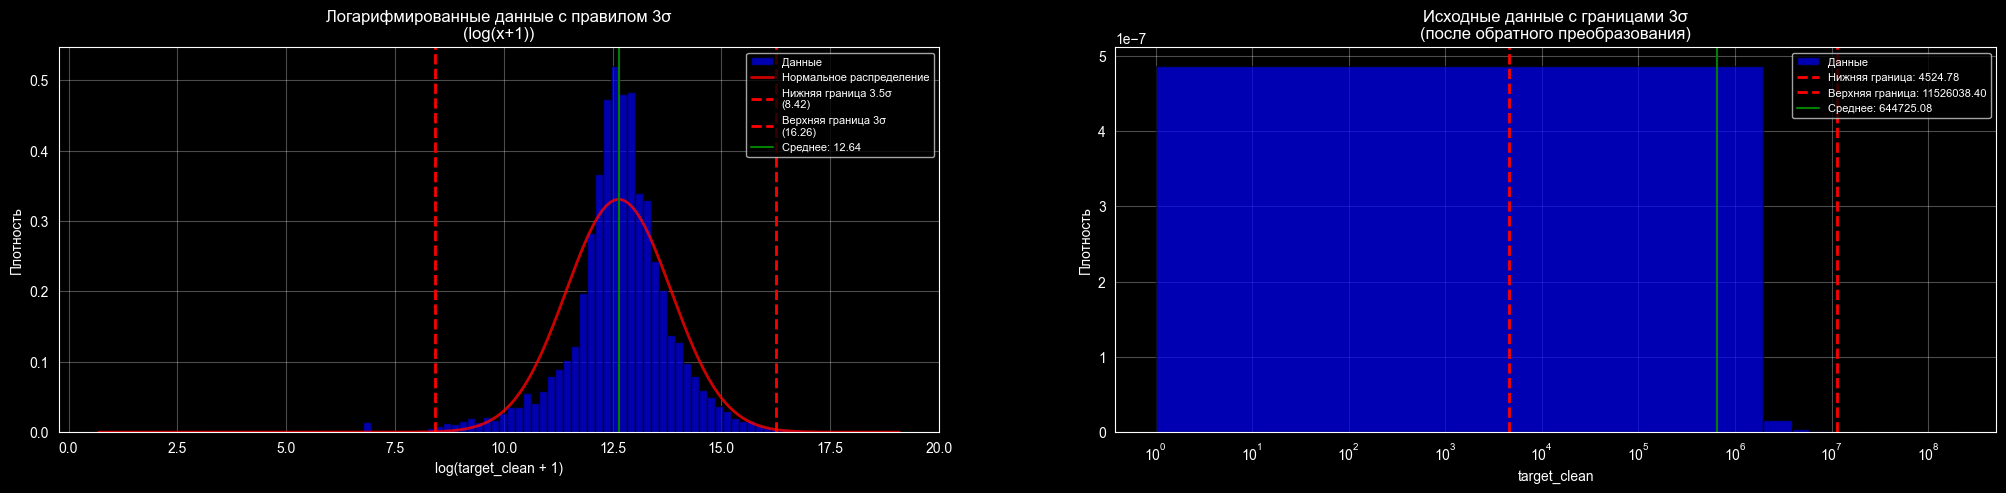

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(25, 5))

# График 1: Исходное распределение (логарифмированное) с границами 3σ
x = np.linspace(data_log.min(), data_log.max(), 1000)
pdf = stats.norm.pdf(x, mean_log, std_log)

axes[0].hist(data_log, bins=100, alpha=0.7, color='blue',
                edgecolor='black', density=True, label='Данные')
axes[0].plot(x, pdf, 'r-', lw=2, alpha=0.8, label='Нормальное распределение')
axes[0].axvline(lower_bound_log, color='red', linestyle='--', linewidth=2,
                   label=f'Нижняя граница 3.5σ\n({lower_bound_log:.2f})')
axes[0].axvline(upper_bound_log, color='red', linestyle='--', linewidth=2,
                   label=f'Верхняя граница 3σ\n({upper_bound_log:.2f})')
axes[0].axvline(mean_log, color='green', linestyle='-', linewidth=1.5,
                   label=f'Среднее: {mean_log:.2f}')
axes[0].set_title('Логарифмированные данные с правилом 3σ\n(log(x+1))')
axes[0].set_xlabel('log(target_clean + 1)')
axes[0].set_ylabel('Плотность')
axes[0].legend(loc='upper right', fontsize=8)
axes[0].grid(True, alpha=0.3)

# График 2: Исходные данные с границами в исходной шкале
axes[1].hist(data['target_clean'], bins=100, alpha=0.7, color='blue',
                edgecolor='black', density=True, label='Данные')
axes[1].axvline(lower_bound_orig, color='red', linestyle='--', linewidth=2,
                   label=f'Нижняя граница: {lower_bound_orig:.2f}')
axes[1].axvline(upper_bound_orig, color='red', linestyle='--', linewidth=2,
                   label=f'Верхняя граница: {upper_bound_orig:.2f}')
axes[1].axvline(data['target_clean'].mean(), color='green', linestyle='-', linewidth=1.5,
                   label=f'Среднее: {data['target_clean'].mean():.2f}')
axes[1].set_title('Исходные данные с границами 3σ\n(после обратного преобразования)')
axes[1].set_xlabel('target_clean')
axes[1].set_ylabel('Плотность')
axes[1].legend(loc='upper right', fontsize=8)
axes[1].grid(True, alpha=0.3)
axes[1].set_xscale('log')  # Логарифмическая шкала для наглядности

По графикам видно, что в оригинале у нас сильное смещение распределения целевого признака, а в логарифме все красиво. Это типично для данных которые связаны со стоимостью.
На правом графике пришлось применить логарифмическую ось x иначе ничег о не видно было бы.

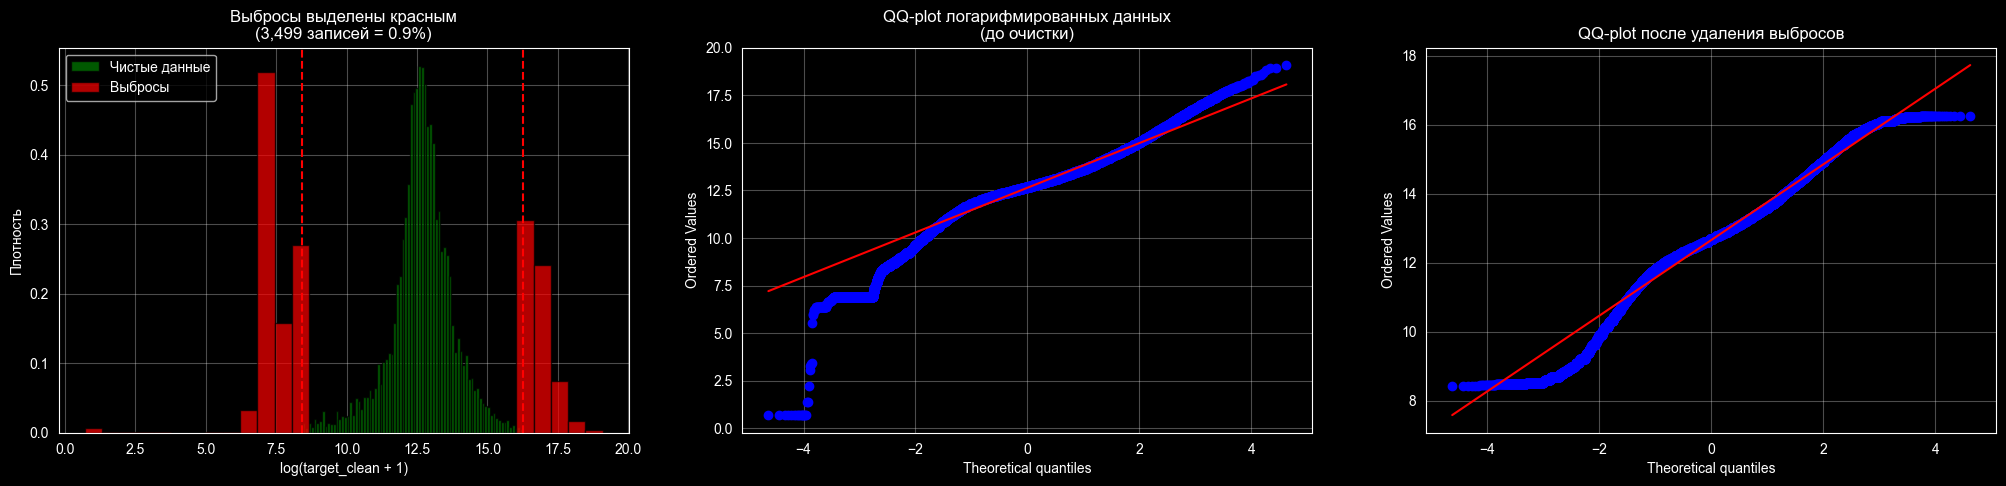

In [36]:
fig, axes = plt.subplots(1, 3, figsize=(25, 5))

# График 3: Выделение выбросов
clean_log = np.log1p(clean_data)
outliers_log = np.log1p(outliers)

axes[0].hist(clean_log, bins=80, alpha=0.7, color='green',
                edgecolor='black', density=True, label='Чистые данные')
axes[0].hist(outliers_log, bins=30, alpha=0.7, color='red',
                edgecolor='black', density=True, label='Выбросы')
axes[0].axvline(lower_bound_log, color='red', linestyle='--', linewidth=1.5)
axes[0].axvline(upper_bound_log, color='red', linestyle='--', linewidth=1.5)
axes[0].set_title(f'Выбросы выделены красным\n({len(outliers):,} записей = {len(outliers)/len(data['target_clean'])*100:.1f}%)')
axes[0].set_xlabel('log(target_clean + 1)')
axes[0].set_ylabel('Плотность')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# График 4: QQ-plot до обработки
stats.probplot(data_log, dist="norm", plot=axes[1])
axes[1].set_title('QQ-plot логарифмированных данных\n(до очистки)')
axes[1].grid(True, alpha=0.3)

# График 5: QQ-plot после очистки
stats.probplot(clean_log, dist="norm", plot=axes[2])
axes[2].set_title('QQ-plot после удаления выбросов')
axes[2].grid(True, alpha=0.3)

# График 6: Сравнение статистик
metrics = ['Количество', 'Среднее', 'Медиана', 'Стандартное отклонение', 'Асимметрия']
before = [len(data['target_clean']), data['target_clean'].mean(), data['target_clean'].median(), data['target_clean'].std(), data['target_clean'].skew()]
after = [len(clean_data), clean_data.mean(), clean_data.median(), clean_data.std(), clean_data.skew()]

По графикам видно, что очистка сделала данные ближе к нормальности, особенно в центральной части. Можно менять интервалы "выбросов" из-за чего бует меняться метрика *МАЕ* если сделать более строгую модель к прмеру 1.5сигмы то метрика *МАЕ* уменьшится почти в половину, максимальная стоимость жилья останется в районе 1 миллиона. Но тогда на дорогих домах модель будет ошибаться сильнее чем на средних. Тут стоит понимать для каких домов и случаев будет использоваться данная модель. Я решил все же сильноне ограничивать модель в данных для обучения. Но если дорогие дома оцениваются в частном порядке и учитываются более расширенные метрики, то модель можно будет переобучить на более узком объеме данных и применять модель для намболее частого случая. Каких-нибудь обычных домов и получить минимальную ошибку.

Для дальнейшей работы будем использовать датафрем после очистки целевого признака

In [37]:
df_clean.head()

,status,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,target,row_id,pool,target_clean
0,Active,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,"$418,000",1,False,418000
1,for sale,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,"$310,000",2,False,310000
2,for sale,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,"$2,895,000",3,True,2895000
3,for sale,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,"$2,395,000",4,False,2395000
4,for sale,lot/land,1524 Kiscoe St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,"$5,000",5,False,5000


### Статус

In [38]:
show_missing_columns(df_clean[['status']])

Всего строк: 371205
Столбцов с пропусками: 1

Колонка  Пропусков  Доля, %
 status      39001    10.51


Для начала разберемя со статусом. По отчету видно, что у нас 11% пропусков. Так же очень много вариантов статуса с разным текстом, но одним смыслом, постараемся нормализовать статусы и заполнить пропуски.

In [39]:
# Применяем к колонке
value_report(df_clean['status'], top_n=100)

MISSING:39001 (10.5%)

| for sale | 41.8% | 155191
| Active | 28.2% | 104515
| For sale | 11.6% | 43176
| New construction | 1.5% | 5446
| foreclosure | 1.3% | 4755
| Pending | 1.3% | 4655
| Pre-foreclosure | 0.5% | 2000
| P | 0.4% | 1488
| Pre-foreclosure / auction | 0.3% | 1281
| Under Contract Show | 0.3% | 1183
|  / auction | 0.2% | 799
| Under Contract   Showing | 0.2% | 793
| Active Under Contract | 0.2% | 718
| Under Contract | 0.2% | 690
| New | 0.2% | 689
| Contingent | 0.2% | 581
| Price Change | 0.2% | 563
| Auction | 0.1% | 493
| A Active | 0.1% | 443
| Foreclosure | 0.1% | 328
| Foreclosed | 0.1% | 294
| Under Contract Backups | 0.1% | 252
| Contingent Finance And Inspection | 0.1% | 240
| Pending Continue To Show | 0.1% | 194
| Option Pending | 0.0% | 110
| Back on Market | 0.0% | 106
| pending | 0.0% | 105
| Contingent Show | 0.0% | 101
| Pending Taking Backups | 0.0% | 63
| Option Contract | 0.0% | 54
| for rent | 0.0% | 51
| Active With Offer | 0.0% | 47
| Pending With

In [40]:
# Получаю все значения
value_counts = df_clean['status'].value_counts()

value_counts.to_csv('./report/status_values.csv')
print("Сохранено в status_values.csv")

Сохранено в status_values.csv


In [41]:
short_status_map = {
    "C": "Continue Show",
    "P": "Pending Sale",
    "U": "Under Contract"
}

def normalize_status(s):
    if pd.isna(s):
        return "missing"
    
    if s in short_status_map:
        return short_status_map[s]

    s = s.lower()

    if "missing" in s:
        return "missing"
    
    if "active" in s or "for sale" in s or "continue show" in s:
        return "active"
    
    if "pending" in s or "contract" in s or "option" in s:
        return "pending/under Contract"
    
    if "contingent" in s:
        return "contingent"
    
    if "auction" in s or "foreclos" in s or "pre-fore" in s:
        return "auction/foreclosure"
    
    if "new" in s or "coming" in s or "extended" in s or "price change" in s or "back on market" in s:
        return "new/coming Soon"
    
    if "sold" in s or "closed" in s:
        return "sold"
    
    if "rent" in s:
        return "rent"
    
    return "other"

df_clean["status_cat"] = df_clean["status"].apply(normalize_status)

In [42]:
df_clean[df_clean["status_cat"] == "other"]["status"].value_counts()


status
Pi                                  36
Due Diligence Period                27
CT Insp - Inspection Contingency    10
Ct                                   5
Contingency 48 Hr (+/ )              5
Pf                                   4
Accepted Offer                       4
Accepting backups                    2
Ps                                   2
Re Activated                         2
Uc Continue To Show                  2
Conting Accpt Backups                1
Lease/Purchase                       1
Reactivated                          1
Backup                               1
Name: count, dtype: int64

В категорию **OTHER** попали редкие статусы

### Тип объекта

In [43]:
show_missing_columns(df_clean[['propertyType']])

Всего строк: 371205
Столбцов с пропусками: 1

     Колонка  Пропусков  Доля, %
propertyType      34161      9.2


In [44]:
# Применяем к колонке
value_report(df_clean['propertyType'], top_n=100)

MISSING:34161 (9.2%)

| single-family home | 24.3% | 90086
| Single Family | 16.6% | 61590
| Single Family Home | 8.5% | 31682
| condo | 6.9% | 25666
| lot/land | 5.4% | 20134
| Condo | 4.4% | 16363
| townhouse | 3.1% | 11344
| Land | 2.9% | 10696
| multi-family | 2.1% | 7739
| Condo/Townhome/Row Home/Co-Op | 2.1% | 7697
| Townhouse | 1.8% | 6863
| Traditional | 1.6% | 5911
| coop | 0.9% | 3226
| Multi Family | 0.7% | 2748
| High Rise | 0.5% | 1815
| Ranch | 0.5% | 1781
| mobile/manufactured | 0.4% | 1613
| Detached, One Story | 0.4% | 1613
| Single Detached, Traditional | 0.4% | 1580
| Contemporary | 0.4% | 1556
| Multi-Family Home | 0.4% | 1492
| 1 Story | 0.3% | 1234
| Colonial | 0.3% | 1204
| Mobile / Manufactured | 0.3% | 1056
| Contemporary/Modern | 0.3% | 998
| 2 Stories | 0.2% | 911
| Mfd/Mobile Home | 0.2% | 791
| Single Detached | 0.2% | 750
| Detached, Two Story | 0.2% | 621
| One Story | 0.2% | 592
| Transitional | 0.2% | 560
| Florida | 0.1% | 530
| Cooperative | 0.1% | 51

In [45]:
# Получаю все значения
value_counts = df_clean['propertyType'].value_counts()

value_counts.to_csv('./report/propertyType_values.csv')
print("Сохранено в propertyType_values.csv")

Сохранено в propertyType_values.csv


In [46]:
def normalize_property_type(s):
    if pd.isna(s):
        return "Missing"
    s = s.lower().strip()

    if "missing" in s or s == "":
        return "Missing"

    # Single Family (самая широкая группа)
    if "single" in s or "detached" in s or "story" in s:
        return "single Family"
    if "traditional" in s or "colonial" in s or "craftsman" in s:
        return "single Family"
    if "ranch" in s or "bungalow" in s or "cape cod" in s:
        return "single Family"
    if "contemporary" in s or "modern" in s or "transitional" in s:
        return "single Family"

    # Condo
    if "condo" in s:
        return "condo"

    # Townhouse
    if "town" in s or "row home" in s:
        return "townhouse"

    # Multi-family
    if "multi" in s or "multiple occupancy" in s:
        return "multi-family"

    # Land
    if "land" in s or "lot" in s:
        return "land"

    # Apartment / Co-op
    if "apart" in s or "coop" in s or "cooperative" in s or "high rise" in s:
        return "apartment/co-Op"

    # Mobile
    if "mobile" in s or "manufact" in s or "mfd" in s:
        return "mobile/manufactured"

    # Farm
    if "farm" in s or "ranch" in s:
        return "farm/ranch"
    
    return "other"

df_clean["propertyType_cat"] = df_clean["propertyType"].apply(normalize_property_type)


In [47]:
df_clean[df_clean["propertyType_cat"] == "other"]["propertyType"].value_counts()

propertyType
2 Stories                911
Florida                  530
Garden Home              305
Spanish/Mediterranean    271
Other Style              249
                        ... 
Penthouse, Low Rise        1
Country English            1
Other - See Remarks        1
Georgian, Other Style      1
Cottage/Camp               1
Name: count, Length: 283, dtype: int64

В категорию **OTHER** попали признаки которые редкие, либо не несут нужных данных по типу постройки.

### Улица

In [48]:
show_missing_columns(df_clean[['street']])

Всего строк: 371205
Столбцов с пропусками: 1

Колонка  Пропусков  Доля, %
 street          2      0.0


Следующий признак с пропусками Улица. Пропусков там немного, но есть строки где заполнено Unknown Address или подобная запись. Нормализуем признак как и остальные до него.

In [49]:
value_report(df_clean['street'], top_n=100)

MISSING:2 (0.0%)

| Address Not Disclosed | 0.2% | 672
| Undisclosed Address | 0.1% | 512
| (undisclosed Address) | 0.1% | 386
| Address Not Available | 0.0% | 175
| Unknown Address | 0.0% | 72
| 2103 E State Hwy 21 | 0.0% | 57
| 11305 Gulf Fwy | 0.0% | 54
| 17030 Youngblood Rd. | 0.0% | 38
| NE 58th Cir | 0.0% | 34
| 9470 Lancaster Rd. SW | 0.0% | 32
| 1 Palmer Dr | 0.0% | 27
| 8426 Terrace Valley Circle | 0.0% | 25
| 9845 Basil Western Rd NW | 0.0% | 25
| 6320 SW 89th Court Road | 0.0% | 24
| 8447 SW 99th Street Rd | 0.0% | 22
| 5221 S. Zapata Hwy | 0.0% | 20
| Whitetail Trail | 0.0% | 19
| Stone Bluff Drive | 0.0% | 18
| 3435 Heather Garden Trail | 0.0% | 17
| Boncher Blvd | 0.0% | 17
| 24423 Ferdossa Drive | 0.0% | 17
| 1365 Neihart Way | 0.0% | 17
| 3423 Heather Garden Trail | 0.0% | 17
| 1727 Opal Field Lane | 0.0% | 17
| 2005 West Happy Valley Road | 0.0% | 17
| 11 Pheasant Drive | 0.0% | 16
| 606 Vineyard Hollow Court | 0.0% | 16
| 50 Leanni Way | 0.0% | 16
| 1024 Dali Blvd. | 

In [50]:
# Получаю все значения
value_counts = df_clean['street'].value_counts()

value_counts.to_csv('./report/street_values.csv')
print("Сохранено в street_values.csv")

Сохранено в street_values.csv


In [51]:
# Список значений, которые считаем как «неизвестный адрес»
undisclosed = ["MISSING", "Address Not Disclosed", "Undisclosed Address",
               "(undisclosed Address)", "Address Not Available", "Unknown Address"]

def normalize_street(s):
    if pd.isna(s) or s in undisclosed:
        return "undisclosed"
    else:
        return "known"
    
df_clean["street"] = df_clean["street"].fillna("MISSING")

df_clean["street_cat"] = df_clean["street"].apply(normalize_street)

В итоге мы получили признак известен адрес или нет.

### Ванные комнаты

In [52]:
show_missing_columns(df_clean[['baths']])

Всего строк: 371205
Столбцов с пропусками: 1

Колонка  Пропусков  Доля, %
  baths     103644    27.92


In [53]:
value_report(df_clean['baths'], top_n=100)

MISSING:103644 (27.9%)

| 2 Baths | 13.9% | 51709
| 3 Baths | 9.5% | 35337
| 2 | 5.5% | 20419
| 2.0 | 4.4% | 16335
| 4 Baths | 3.9% | 14645
| 3.0 | 2.9% | 10789
| 3 | 2.7% | 10087
| Bathrooms: 2 | 2.5% | 9407
| 2.5 | 2.2% | 8113
| Bathrooms: 3 | 1.8% | 6568
| 1 | 1.8% | 6544
| 1.0 | 1.6% | 5779
| 5 Baths | 1.4% | 5277
| 4.0 | 1.2% | 4549
| 2.5 Baths | 1.2% | 4392
| 0 | 1.0% | 3694
| 4 | 1.0% | 3546
| 3.5 | 0.9% | 3455
| Bathrooms: 1 | 0.8% | 3123
| 2 ba | 0.7% | 2679
| 6 Baths | 0.7% | 2528
| Bathrooms: 4 | 0.6% | 2370
| 1,500 | 0.6% | 2205
| 3 ba | 0.5% | 1884
| 1.5 | 0.5% | 1857
| 3.5 Baths | 0.5% | 1799
| 2,000 | 0.5% | 1791
| 1,750 | 0.5% | 1717
| 3,000 | 0.5% | 1682
| 5.0 | 0.4% | 1531
| 2,250 | 0.4% | 1440
| 1,000 | 0.3% | 1270
| 1,250 | 0.3% | 1203
| 5 | 0.3% | 1196
| 7 Baths | 0.3% | 1143
| 4.5 | 0.3% | 1015
| 2,750 | 0.3% | 963
| 2,500 | 0.2% | 890
| Bathrooms: 5 | 0.2% | 819
| ~ | 0.2% | 772
| 1 ba | 0.2% | 747
| 4 ba | 0.2% | 734
| 6.0 | 0.2% | 708
| 3,500 | 0.2% | 651
| 8 B

In [54]:
# Получаю все значения
value_counts = df_clean['baths'].value_counts()

value_counts.to_csv('./report/baths_values.csv')
print("Сохранено в baths_values.csv")

Сохранено в baths_values.csv


Признак очень грязный. Нужно его очистить и привести в порядок.

In [55]:
# вычисляем моду среди нормальных значений (1–10)
valid_baths = df_clean["baths"].apply(lambda x: re.search(r"(\d+(\.\d+)?)", str(x).replace(",", "")))
valid_baths = valid_baths[valid_baths.notnull()].apply(lambda m: float(m.group(1)))
valid_baths = valid_baths[(valid_baths >= 1) & (valid_baths <= 10)]
mode_baths = Counter(valid_baths).most_common(1)[0][0]

def clean_baths(x, mode_val):
    if pd.isna(x) or str(x).strip().lower() in ["missing", ""]:
        return 0
    x_str = str(x).lower().strip()
    match = re.search(r"(\d+(\.\d+)?)", x_str.replace(",", "."))
    if match:
        val = float(match.group(1))
        if val > 10:
            return mode_val
        return val
    return mode_val

df_clean["baths_clean"] = df_clean["baths"].apply(lambda x: clean_baths(x, mode_baths))


In [56]:
df_clean.head()

,status,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,...,state,stories,target,row_id,pool,target_clean,status_cat,propertyType_cat,street_cat,baths_clean
0,Active,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,...,NC,NaN,"$418,000",1,False,418000,active,single Family,known,3.5
1,for sale,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,...,WA,2.0,"$310,000",2,False,310000,active,single Family,known,3.0
2,for sale,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,...,CA,1.0,"$2,895,000",3,True,2895000,active,single Family,known,2.0
3,for sale,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,...,TX,3.0,"$2,395,000",4,False,2395000,active,single Family,known,8.0
4,for sale,lot/land,1524 Kiscoe St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,...,FL,NaN,"$5,000",5,False,5000,active,land,known,0.0


### Сведенья о доме

In [57]:
show_missing_columns(df_clean[['homeFacts']])

Пропусков нет!


In [58]:
value_report(df_clean['homeFacts'], top_n=100)

MISSING:0 (0.0%)

| {'atAGlanceFacts': [{'factValue': '', 'factLabel': 'Year built'}, {'factValue': '', 'factLabel': 'Remodeled year'}, {'factValue': '', 'factLabel': 'Heating'}, {'factValue': '', 'factLabel': 'Cooling'}, {'factValue': '', 'factLabel': 'Parking'}, {'factValue': '—', 'factLabel': 'lotsize'}, {'factValue': None, 'factLabel': 'Price/sqft'}]} | 1.9% | 6955
| {'atAGlanceFacts': [{'factValue': None, 'factLabel': 'Year built'}, {'factValue': None, 'factLabel': 'Remodeled year'}, {'factValue': None, 'factLabel': 'Heating'}, {'factValue': None, 'factLabel': 'Cooling'}, {'factValue': None, 'factLabel': 'Parking'}, {'factValue': None, 'factLabel': 'lotsize'}, {'factValue': None, 'factLabel': 'Price/sqft'}]} | 0.9% | 3457
| {'atAGlanceFacts': [{'factValue': '', 'factLabel': 'Year built'}, {'factValue': '', 'factLabel': 'Remodeled year'}, {'factValue': '', 'factLabel': 'Heating'}, {'factValue': '', 'factLabel': 'Cooling'}, {'factValue': '', 'factLabel': 'Parking'}, {'factValue': ''

Пропуски есть, просто они содержатся внутри словаря. Сам словарь есть в каждой строке.

In [59]:
# Получаю все значения
value_counts = df_clean['homeFacts'].value_counts()

value_counts.to_csv('./report/homeFacts_values.csv')
print("Сохранено в homeFacts_values.csv")

Сохранено в homeFacts_values.csv


Видим, что внутри у нас словарь. Разобьем его на признаки по ключевым словам.

In [60]:
df_clean_hf = df_clean[['row_id', 'homeFacts']].copy()

In [61]:
def extract_home_facts(x):
    def clean_value(v):
    
        if v in [None, '', '—', 'No Data']:
            return 0
        
        # если это строка: убираем пробелы и мусор
        if isinstance(v, str):
            v = v.strip()
            # оставляем только цифры, если это похоже на число
            v_digits = re.sub(r'[^0-9]', '', v)
            if v_digits.isdigit():
                return int(v_digits)
            return v  # если нет цифр — оставить как есть (категориальное значение)
        
        return v  # числа вернуть как есть

    result = {}
    try:
        data_list = ast.literal_eval(x)
        for fact in data_list.get('atAGlanceFacts', []):
            val = clean_value(fact.get('factValue'))
            label = fact.get('factLabel')
            result[label] = val

    except:
        result = {
            'Year built': 0,
            'Remodeled year': 0,
            'Heating': 0,
            'Cooling': 0,
            'Parking': 0,
            'lotsize': 0,
            'Price/Sqft': 0
        }

    return result

# применяем и разворачиваем в отдельные колонки
home_facts_df = df_clean_hf['homeFacts'].apply(extract_home_facts).apply(pd.Series)

# объединяем с основным датафреймом
df_clean_hf = pd.concat([df_clean_hf, home_facts_df], axis=1)

In [62]:
df_clean_hf.head(100)

,row_id,homeFacts,Year built,Remodeled year,Heating,Cooling,Parking,lotsize,Price/sqft
0,1,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",2019,0,"Central A/C, Heat Pump",0,0,0,144
1,2,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",2019,0,0,0,0,5828,159
2,3,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",1961,1967,Forced Air,Central,Attached Garage,8626,965
3,4,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",2006,2006,Forced Air,Central,Detached Garage,8220,371
4,5,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",0,0,0,0,0,10019,0
...,...,...,...,...,...,...,...,...,...
97,98,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",0,0,0,0,0,0,192
98,99,"{'atAGlanceFacts': [{'factValue': '1952', 'fac...",1952,1952,Central Air,Has Cooling,0,141,217
99,100,"{'atAGlanceFacts': [{'factValue': '1977', 'fac...",1977,1978,Forced Air,Central,0,0,78
100,101,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",2019,0,0,0,2,0,115


Добавили новые признаки, теперь доработаем их.

Отопление

In [63]:
show_missing_columns(df_clean_hf[['Heating']])

Пропусков нет!


In [64]:
value_report(df_clean_hf['Heating'], top_n=100)

MISSING:0 (0.0%)

| 0 | 31.1% | 115559
| Forced Air | 21.9% | 81342
| Forced air | 13.7% | 50837
| Other | 7.8% | 28886
| Electric | 2.7% | 10030
| Gas | 2.5% | 9238
| Central Air | 2.1% | 7756
| Central Electric | 1.9% | 7110
| Central | 1.7% | 6243
| Heat Pump | 1.6% | 6072
| Central, Electric | 1.1% | 4252
| Baseboard | 1.0% | 3763
| Wall | 0.9% | 3262
| Electric Heat | 0.8% | 3063
| Heat pump | 0.7% | 2724
| Heating System | 0.7% | 2705
| Forced air, Heat pump | 0.5% | 1720
| Radiant | 0.4% | 1475
| Central Air, Ceiling Fan(s) | 0.4% | 1428
| Natural Gas Heat | 0.4% | 1383
| Central Furnace | 0.3% | 1011
| Forced Air, Gas | 0.3% | 962
| Central Electric, Zoned | 0.2% | 868
| Forced Air Heating | 0.2% | 810
| , Gas Hot Air/Furnace | 0.2% | 776
| Gas Heat | 0.2% | 769
| Forced Air, Natural Gas | 0.2% | 737
| Central Heating | 0.2% | 646
| Central Gas | 0.2% | 630
| Central Electric, Heat Pump | 0.1% | 517
| , Heat Pump - Heat | 0.1% | 499
| Central Air Conditioning | 0.1% | 396
| Ele

In [65]:
df_clean_hf['Heating'] = df_clean_hf['Heating'].fillna('').astype(str)
df_clean_hf['Heating'] = df_clean_hf['Heating'].str.replace(',', '', regex=False).str.lower()
df_clean_hf['Heating'] = df_clean_hf['Heating'].str.strip()

In [66]:
def categorize_heating(value):

    if pd.isna(value) or value == 'missing':
        return 'Missing'
    
    text = str(value).lower()
    
    # Основные 10 категорий
    if 'forced air' in text or 'forcedair' in text:
        return 'forced air'
    
    if 'heat pump' in text:
        return 'heatpump'
    
    if 'central' in text:
        return 'central'
    
    if 'electric' in text:
        return 'electric'
    
    if 'gas' in text or 'natural' in text:
        return 'gas'
    
    if 'baseboard' in text:
        return 'baseboard'
    
    if 'wall' in text and 'window' not in text:
        return 'wall heater'
    
    if 'radiant' in text or 'hot water' in text or 'steam' in text:
        return 'radiant/water'
    
    if text == 'other':
        return 'other'
    
    if 'none' in text or 'no cooling' in text:
        return 'none'
    
    return 'other'

df_clean_hf["heating_cat"] = df_clean_hf["Heating"].apply(categorize_heating)

Охлаждение.

In [67]:
show_missing_columns(df_clean_hf['Cooling'])

Пропусков нет!


In [68]:
value_report(df_clean_hf['Cooling'], top_n=100)

MISSING:0 (0.0%)

| Central | 42.3% | 156900
| 0 | 35.3% | 130917
| Central Air | 3.9% | 14380
| Has Cooling | 2.6% | 9661
| None | 2.0% | 7280
| Central Electric | 1.7% | 6153
| Wall | 1.1% | 3983
| Central Gas | 1.0% | 3573
| Central Heating | 0.8% | 2806
| Cooling System | 0.7% | 2696
| Central A/C | 0.5% | 2034
| Other | 0.5% | 1767
| Central A/C (Electric), Central Heat (Gas) | 0.4% | 1643
| Central A/C (Electric), Central Heat (Electric) | 0.4% | 1429
| Refrigeration | 0.3% | 1061
| Central, Electric | 0.3% | 1059
| Electric | 0.3% | 1009
| Evaporative | 0.3% | 987
| 2 | 0.2% | 832
| Central Air, Gas Hot Air/Furnace | 0.2% | 827
| Refrigeration, Ceiling Fan(s) | 0.2% | 787
| Central Gas, Zoned | 0.2% | 743
| Central, Wall | 0.2% | 719
| Air Conditioning-Central | 0.2% | 637
| Has Heating | 0.2% | 582
| Central Air, Gas (Hot Air) | 0.1% | 504
| Central Electric, Zoned | 0.1% | 464
| Central Air, Zoned | 0.1% | 452
| Solar, Refrigeration | 0.1% | 420
| Central, Other | 0.1% | 415
|

In [69]:
def categorize_cooling(value):

    if pd.isna(value) or value == 'missing' or str(value) == '0':
        return 'Missing'
    
    text = str(value).lower()
    
    # Основные категории охлаждения
    if 'central air' in text or 'central a/c' in text or 'air conditioning-central' in text:
        return 'central air'
    
    if 'central' in text and ('cooling' not in text and 'electric' not in text and 'gas' not in text):
        return 'central'
    
    if 'refrigeration' in text:
        return 'refrigeration'
    
    if 'evaporative' in text or 'swamp' in text:
        return 'evaporative'
    
    if 'heat pump' in text:
        return 'heat pump'
    
    if 'window' in text or 'wall/window' in text or 'wall unit' in text:
        return 'window/wall unit'
    
    if 'electric' in text:
        return 'electric'
    
    if 'gas' in text:
        return 'gas'
    
    if 'none' in text or 'no heating' in text:
        return 'none'
    
    if 'other' in text:
        return 'other'
    
    if 'has cooling' in text or 'cooling system' in text:
        return 'has cooling'
    
    # Цифры и мусор
    if text in ['1', '2', '3', '90', 'has heating']:
        return 'other'
    
    # Всё остальное
    return 'other'

# Применяем
df_clean_hf['cooling_cat'] = df_clean_hf['Cooling'].apply(categorize_cooling)

Парковка

In [70]:
show_missing_columns(df_clean_hf[['Parking']])

Пропусков нет!


In [71]:
value_report(df_clean_hf['Parking'], top_n=100)

MISSING:0 (0.0%)

| 0 | 50.3% | 186561
| Attached Garage | 18.8% | 69713
| 2 | 8.9% | 32915
| 1 | 4.7% | 17475
| Detached Garage | 3.5% | 12989
| Carport | 2.1% | 7650
| 3 | 1.5% | 5521
| 4 | 1.0% | 3597
| Off Street | 1.0% | 3552
| Carport, Attached Garage | 0.8% | 2997
| None | 0.6% | 2342
| Off street | 0.4% | 1620
| On Street | 0.3% | 1235
| Attached Garage, Detached Garage | 0.3% | 1178
| Attached Garage, Carport | 0.3% | 984
| 6 | 0.3% | 936
| Parking Desc | 0.2% | 899
| 5 | 0.2% | 785
| Driveway | 0.2% | 693
| Detached Garage, Attached Garage | 0.2% | 641
| On street | 0.1% | 459
| Parking Type | 0.1% | 447
| Off Street, Attached Garage | 0.1% | 443
| Off street parking | 0.1% | 430
| Carport, Detached Garage | 0.1% | 396
| Garage Type | 0.1% | 374
| Parking YN | 0.1% | 366
| Driveway, Garage Door Opener | 0.1% | 340
| 8 | 0.1% | 276
| Garage Door Opener | 0.1% | 263
| Attached Garage, Off Street | 0.1% | 244
| 888 | 0.1% | 242
| Attached - FRONT | 0.1% | 233
| Slab Parking Spac

In [72]:
def categorize_parking(value):

    if pd.isna(value) or str(value) == '0':
        return 'Missing'
    
    text = str(value).lower()
    
    # Основные типы парковки
    if 'attached garage' in text or 'garage-attached' in text or 'garage attached' in text:
        return 'attached garage'
    
    if 'detached garage' in text or 'detached parking' in text:
        return 'detached garage'
    
    if 'carport' in text:
        return 'carport'
    
    if 'off street' in text or 'offstreet' in text:
        return 'off street'
    
    if 'on street' in text or 'onstreet' in text:
        return 'on street'
    
    if 'driveway' in text:
        return 'driveway'
    
    if 'none' in text:
        return 'none'
    
    if text.isdigit():
        num = int(text)
        if num <= 0:
            return 'missing'
        elif num == 1:
            return '1_Space'
        elif num == 2:
            return '2_Spaces'
        elif num == 3:
            return '3_Spaces'
        elif num <= 6:
            return '4-6_Spaces'
        else:
            return '7+_Spaces'
    
    if 'parking' in text and ('desc' in text or 'type' in text or 'yn' in text):
        return 'Other Parking'
    
    # Всё остальное
    return 'other'

# Применяем
df_clean_hf['parking_cat'] = df_clean_hf['Parking'].apply(categorize_parking)

Размер участка.

In [73]:
show_missing_columns(df_clean_hf[['lotsize']])

Пропусков нет!


In [74]:
value_report(df_clean_hf['lotsize'], top_n=100)

MISSING:0 (0.0%)

| 0 | 24.4% | 90458
| -- sqft lot | 1.0% | 3796
| 26 | 0.9% | 3395
| 25 | 0.8% | 3014
| 28 | 0.8% | 2864
| 27 | 0.7% | 2706
| 6098 | 0.7% | 2674
| 7405 | 0.7% | 2663
| 10000 | 0.7% | 2636
| 29 | 0.7% | 2560
| 6534 | 0.6% | 2198
| 5000 | 0.6% | 2152
| 34 | 0.6% | 2098
| 8712 | 0.5% | 1983
| 8276 | 0.5% | 1919
| 5227 | 0.5% | 1913
| 31 | 0.5% | 1880
| 4356 | 0.5% | 1753
| 10019 | 0.5% | 1742
| 32 | 0.5% | 1697
| 1 | 0.5% | 1694
| 3 | 0.4% | 1656
| 9583 | 0.4% | 1621
| 33 | 0.4% | 1561
| 10454 | 0.4% | 1527
| 35 | 0.4% | 1474
| 46 | 0.4% | 1359
| 36 | 0.4% | 1325
| 10018 | 0.4% | 1301
| 37 | 0.3% | 1266
| 3920 | 0.3% | 1259
| 4791 | 0.3% | 1255
| 7500 | 0.3% | 1227
| 6969 | 0.3% | 1171
| 7840 | 0.3% | 1125
| 39 | 0.3% | 1088
| 38 | 0.3% | 1084
| 6000 | 0.3% | 1075
| 4792 | 0.3% | 1073
| 5 | 0.3% | 1069
| 3049 | 0.3% | 1047
| 5662 | 0.3% | 1000
| 6970 | 0.3% | 972
| 41 | 0.3% | 971
| 2500 | 0.3% | 963
| 7841 | 0.3% | 958
| 2178 | 0.3% | 957
| 2000 | 0.2% | 919
| 7000 | 0.

In [75]:
# очистка и перевод в sqft
def clean_lotsize(x):
    if pd.isna(x) or str(x).lower() in ["missing", "no data", "(other)"]:
        return 0
    x_str = str(x).lower().replace(",", "").strip()
    if "acre" in x_str:
        match = re.search(r"([\d\.]+)", x_str)
        if match:
            return int(float(match.group(1)) * 43560)
    elif "sqft" in x_str or "sq. ft." in x_str:
        match = re.search(r"([\d\.]+)", x_str)
        if match:
            return float(match.group(1))
    else:
        match = re.search(r"([\d\.]+)", x_str)
        if match:
            return float(match.group(1))
    return 0

df_clean_hf["lotsize_clean"] = df_clean_hf["lotsize"].apply(clean_lotsize)

# категориальный признак по типам застройки США
def categorize_lotsize(x):
    if pd.isna(x):
        return "missing"
    elif x < 1500:
        return "urban_condo"
    elif x < 3000:
        return "urban_rowhouse"
    elif x < 5000:
        return "urban_small_lot"
    elif x < 7500:
        return "urban_standard"
    elif x < 10000:
        return "suburban_small"
    elif x < 21780:
        return "suburban_quarter"
    elif x < 43560:
        return "suburban_half"
    elif x < 108900:
        return "suburban_full"
    elif x < 217800:
        return "rural_small"
    else:
        return "rural_large"


df_clean_hf["lotsize_cat"] = df_clean_hf["lotsize_clean"].apply(categorize_lotsize)


In [76]:
# Уникальные параметры
print(df_clean_hf['lotsize_cat'].value_counts())

lotsize_cat
urban_condo         182563
urban_standard       59681
suburban_small       43944
urban_small_lot      28345
suburban_quarter     24076
urban_rowhouse       20823
suburban_half         3682
suburban_full         3467
rural_large           3223
rural_small           1401
Name: count, dtype: int64


Цена за квадрат.

In [77]:
show_missing_columns(df_clean_hf[['Price/sqft']])

Пропусков нет!


In [78]:
value_report(df_clean_hf['Price/sqft'], top_n=100)

MISSING:0 (0.0%)

| 0 | 16.6% | 61525
| 125 | 0.5% | 1719
| 121 | 0.5% | 1709
| 128 | 0.5% | 1707
| 123 | 0.5% | 1702
| 127 | 0.5% | 1696
| 132 | 0.5% | 1687
| 130 | 0.5% | 1682
| 122 | 0.5% | 1681
| 133 | 0.5% | 1673
| 115 | 0.5% | 1671
| 118 | 0.5% | 1671
| 135 | 0.4% | 1658
| 124 | 0.4% | 1639
| 141 | 0.4% | 1638
| 117 | 0.4% | 1637
| 116 | 0.4% | 1635
| 120 | 0.4% | 1625
| 139 | 0.4% | 1618
| 138 | 0.4% | 1614
| 119 | 0.4% | 1614
| 140 | 0.4% | 1608
| 131 | 0.4% | 1600
| 111 | 0.4% | 1594
| 129 | 0.4% | 1589
| 134 | 0.4% | 1575
| 136 | 0.4% | 1574
| 137 | 0.4% | 1562
| 143 | 0.4% | 1562
| 126 | 0.4% | 1555
| 114 | 0.4% | 1545
| 146 | 0.4% | 1528
| 142 | 0.4% | 1516
| 110 | 0.4% | 1503
| 147 | 0.4% | 1488
| 150 | 0.4% | 1480
| 113 | 0.4% | 1479
| 145 | 0.4% | 1477
| 144 | 0.4% | 1465
| 100 | 0.4% | 1463
| 112 | 0.4% | 1463
| 149 | 0.4% | 1447
| 148 | 0.4% | 1446
| 109 | 0.4% | 1443
| 108 | 0.4% | 1428
| 103 | 0.4% | 1414
| 106 | 0.4% | 1412
| 152 | 0.4% | 1399
| 104 | 0.4% | 1393
| 

In [79]:
def clean_price_per_sqft(x):
    if pd.isna(x):
        return 0
    x_str = str(x).strip().lower()
    if "no data" in x_str or "no info" in x_str or "(other)" in x_str:
        return 0
    
    m = re.search(r"[\d]{1,3}(?:[,\d]{0,})(?:\.\d+)?", x_str)
    if not m:
        m = re.search(r"\d+", x_str)
    if not m:
        return 0

    num_str = m.group(0).replace(",", "")  # 1,234 -> 1234
    try:
        return float(num_str)
    except:
        return 0

df_clean_hf['pricePerSqft_clean'] = df_clean_hf['Price/sqft'].apply(clean_price_per_sqft)


### Школы.

In [80]:
show_missing_columns(df_clean[['schools']])

Пропусков нет!


In [81]:
value_report(df_clean['schools'], top_n=100)

MISSING:0 (0.0%)

| [{'rating': [], 'data': {'Distance': [], 'Grades': []}, 'name': []}] | 1.1% | 4119
| [{'rating': ['4/10', '5/10', '6/10'], 'data': {'Distance': ['39.69mi', '39.69mi', '39.69mi'], 'Grades': ['9-12', '6-8', 'PK-5']}, 'name': ['Fort Hancock High School', 'Fort Hancock Middle School', 'Benito Martinez Elementary School']}] | 0.1% | 222
| [{'rating': ['4/10', '6/10', '3/10'], 'data': {'Distance': ['3.62mi', '3.62mi', '3.62mi'], 'Grades': ['6-8', 'PK-5', '9-12']}, 'name': ['Horizon Middle School', 'Desert Hills Elementary School', 'Horizon High School']}] | 0.0% | 168
| [{'rating': ['5/10', '3/10', '5/10'], 'data': {'Distance': ['9.71mi', '8.92mi', '1.56mi'], 'Grades': ['5-8', '9-12', 'K-4']}, 'name': ['Cheatham Middle School', 'Cheatham Co Central', 'West Cheatham Elementary School']}] | 0.0% | 133
| [{'rating': ['10/10', '2/10'], 'data': {'Distance': ['22.4 mi', '1.5 mi'], 'Grades': ['PK-8', '9-12']}, 'name': ['Air Base Elementary School', 'Booker T. Washington Senior H

Аналогичная ситуация, пропусков типо нет, но есть незаполненые словари.

In [82]:
df_clean_sh = df_clean[['row_id', 'schools']].copy()

In [83]:
def parse_schools(schools_str):

    if pd.isna(schools_str) or schools_str == '':
        return []

    # Если уже список
    if isinstance(schools_str, list):
        return schools_str

    # Пробуем разные методы парсинга
    try:
        # Метод 1: ast.literal_eval
        parsed = ast.literal_eval(str(schools_str))
        if isinstance(parsed, list):
            return parsed
    except:
        try:
            # Метод 2: json с заменой None
            json_str = str(schools_str).replace("'", '"').replace('None', 'null')
            parsed = json.loads(json_str)
            if isinstance(parsed, list):
                return parsed
        except:
            pass

    return []

df_clean_sh['schools_parsed'] = df_clean_sh['schools'].apply(parse_schools)

In [84]:
# Проверим типы столбцов
print(f"Тип первого элемента в 'schools': {type(df_clean_sh['schools'].iloc[0])}")
print(f"Тип первого элемента в 'schools_parsed': {type(df_clean_sh['schools_parsed'].iloc[0])}")

Тип первого элемента в 'schools': <class 'str'>
Тип первого элемента в 'schools_parsed': <class 'list'>


Наш признак сменил класс на список.

Дальше будем извлекать признаки.

In [85]:
def extract_numeric_ratings(schools_list):

    if not isinstance(schools_list, list):
        return []

    numeric_ratings = []

    for school in schools_list:
        if not isinstance(school, dict):
            continue

        ratings = school.get('rating', [])
        if not isinstance(ratings, list):
            continue

        for rating_str in ratings:
            if not isinstance(rating_str, str):
                continue

            # NR → 0
            if rating_str.strip().upper() == "NR":
                numeric_ratings.append(0)
                continue

            # Берём первое число
            match = re.search(r'\d+', rating_str)
            if match:
                try:
                    numeric_ratings.append(int(match.group()))
                except:
                    pass

    return numeric_ratings

# Применяем и создаем признаки
df_clean_sh['school_ratings_list'] = df_clean_sh['schools_parsed'].apply(extract_numeric_ratings)

# Средний рейтинг
df_clean_sh['avg_school_rating'] = df_clean_sh['school_ratings_list'].apply(
    lambda x: round(np.mean(x), 2) if x else 0
)

# Максимальный рейтинг
df_clean_sh['max_school_rating'] = df_clean_sh['school_ratings_list'].apply(
    lambda x: max(x) if x else 0
)

# Количество школ с рейтингом >= 7/10
df_clean_sh['num_good_schools'] = df_clean_sh['school_ratings_list'].apply(
    lambda x: sum(1 for r in x if r >= 7) if x else 0
)

print("Статистика рейтингов школ:")
print(f"Средний рейтинг: {df_clean_sh['avg_school_rating'].mean():.1f}/10")
print(f"Школ с рейтингом >=7: {df_clean_sh['num_good_schools'].sum()}")

Статистика рейтингов школ:
Средний рейтинг: 4.9/10
Школ с рейтингом >=7: 424081


In [86]:
def extract_distances(schools_list):

    if not isinstance(schools_list, list):
        return []

    distances = []
    for school in schools_list:
        if isinstance(school, dict):
            data_dict = school.get('data', {})
            if isinstance(data_dict, dict):
                dist_list = data_dict.get('Distance', [])
                if isinstance(dist_list, list):
                    for dist_str in dist_list:
                        if dist_str and isinstance(dist_str, str):
                            # Ищем число перед 'mi'
                            match = re.search(r'(\d+\.?\d*)', dist_str)
                            if match:
                                try:
                                    distances.append(float(match.group(1)))
                                except:
                                    pass

    return distances

# Применяем и создаем признаки
df_clean_sh['school_distances'] = df_clean_sh['schools_parsed'].apply(extract_distances)

# Минимальное расстояние
df_clean_sh['min_school_distance_mi'] = df_clean_sh['school_distances'].apply(
    lambda x: min(x) if x else 0
)

# Среднее расстояние
df_clean_sh['avg_school_distance_mi'] = df_clean_sh['school_distances'].apply(
    lambda x: round(np.mean(x), 2) if x else 0
)

# Количество школ в пределах 1 мили
df_clean_sh['schools_within_1mi'] = df_clean_sh['school_distances'].apply(
    lambda x: sum(1 for d in x if d <= 1) if x else 0
)

print("\nСтатистика расстояний:")
print(f"Среднее расстояние: {df_clean_sh['avg_school_distance_mi'].mean():.1f} mi")
print(f"Школ в пределах 1 мили: {df_clean_sh['schools_within_1mi'].sum()}")


Статистика расстояний:
Среднее расстояние: 2.8 mi
Школ в пределах 1 мили: 491766


In [87]:
def analyze_grades(schools_list):

    if not isinstance(schools_list, list):
        return {
            'elementary': False, 'middle': False, 'high': False,
            'special': False, 'grades_list': []
        }

    grades_found = []
    for school in schools_list:
        if isinstance(school, dict):
            data_dict = school.get('data', {})
            if isinstance(data_dict, dict):
                grades_list = data_dict.get('Grades', [])
                if isinstance(grades_list, list):
                    grades_found.extend([str(g).upper() for g in grades_list])

    # Анализируем найденные grades
    grades_str = ' '.join(grades_found)

    # Более точное определение
    has_elementary = any(g in grades_str for g in ['PK-5', 'K-5', 'PK-6', 'K-6', 'PK-8', '1-5', '1-6'])
    has_middle = any(g in grades_str for g in ['6-8', '7-8', '6-9', '5-8'])
    has_high = any(g in grades_str for g in ['9-12', '10-12', '9-10'])
    has_special = any(g in grades_str for g in ['K-9', 'K-12', 'PK-12', '6-12'])

    return {
        'has_elementary': has_elementary,
        'has_middle': has_middle,
        'has_high': has_high,
        'has_special': has_special,
        'grades_list': list(set(grades_found))
    }

# Применяем
grades_info = df_clean_sh['schools_parsed'].apply(analyze_grades)

# Создаем бинарные признаки
df_clean_sh['has_elementary_school'] = grades_info.apply(lambda x: x['has_elementary'])
df_clean_sh['has_middle_school'] = grades_info.apply(lambda x: x['has_middle'])
df_clean_sh['has_high_school'] = grades_info.apply(lambda x: x['has_high'])
df_clean_sh['has_special_school'] = grades_info.apply(lambda x: x['has_special'])

# Создаем комбинированный признак
df_clean_sh['school_levels_count'] = (
    df_clean_sh['has_elementary_school'].astype(int) +
    df_clean_sh['has_middle_school'].astype(int) +
    df_clean_sh['has_high_school'].astype(int)
)

print("\nСтатистика уровней школ:")
print(f"Начальные: {df_clean_sh['has_elementary_school'].sum()}")
print(f"Средние: {df_clean_sh['has_middle_school'].sum()}")
print(f"Старшие: {df_clean_sh['has_high_school'].sum()}")
print(f"Разные уровни доступно: {df_clean_sh['school_levels_count'].mean():.1f}")


Статистика уровней школ:
Начальные: 217865
Средние: 202000
Старшие: 226700
Разные уровни доступно: 1.7


In [88]:
def extract_school_names_info(schools_list):

    if not isinstance(schools_list, list):
        return {'names': [], 'types': []}

    names = []
    school_types = []

    for school in schools_list:
        if isinstance(school, dict):
            name_list = school.get('name', [])
            if name_list and isinstance(name_list, list) and len(name_list) > 0:
                name = str(name_list[0]).upper()
                names.append(name)

                # Определяем тип школы по названию
                if any(word in name for word in ['ELEMENTARY', 'PRIMARY']):
                    school_types.append('elementary')
                elif any(word in name for word in ['MIDDLE', 'JUNIOR']):
                    school_types.append('middle')
                elif any(word in name for word in ['HIGH', 'SENIOR']):
                    school_types.append('high')
                elif any(word in name for word in ['ACADEMY', 'CHARTER']):
                    school_types.append('charter')
                elif any(word in name for word in ['INSTITUTE', 'TECH', 'VOC']):
                    school_types.append('vocational')
                elif any(word in name for word in ['MAGNET', 'MONTESSORI']):
                    school_types.append('special')
                else:
                    school_types.append('other')

    return {'names': names, 'types': school_types}

# Применяем
schools_info = df_clean_sh['schools_parsed'].apply(extract_school_names_info)

# Создаем признаки по типам школ
def count_school_type(info, school_type):
    return sum(1 for t in info['types'] if t == school_type)

df_clean_sh['num_elementary_schools'] = schools_info.apply(lambda x: count_school_type(x, 'elementary'))
df_clean_sh['num_middle_schools'] = schools_info.apply(lambda x: count_school_type(x, 'middle'))
df_clean_sh['num_high_schools'] = schools_info.apply(lambda x: count_school_type(x, 'high'))
df_clean_sh['num_charter_schools'] = schools_info.apply(lambda x: count_school_type(x, 'charter'))

print("\nКоличество школ по типам:")
print(f"Начальных: {df_clean_sh['num_elementary_schools'].sum()}")
print(f"Средних: {df_clean_sh['num_middle_schools'].sum()}")
print(f"Старших: {df_clean_sh['num_high_schools'].sum()}")


Количество школ по типам:
Начальных: 218455
Средних: 35174
Старших: 60436


In [89]:
def calculate_school_district_score(row):

    score = 0

    # Базовые баллы за количество школ
    num_schools = len(row.get('school_ratings_list', []))
    if num_schools >= 5:
        score += 3
    elif num_schools >= 3:
        score += 2
    elif num_schools >= 1:
        score += 1

    # Качество школ (средний рейтинг)
    avg_rating = row.get('avg_school_rating', 0)
    if avg_rating >= 8:
        score += 3
    elif avg_rating >= 6:
        score += 2
    elif avg_rating >= 4:
        score += 1

    # Близость школ
    min_dist = row.get('min_school_distance_mi', 100)
    if min_dist <= 0.5:
        score += 3
    elif min_dist <= 1:
        score += 2
    elif min_dist <= 2:
        score += 1

    # Разнообразие уровней
    levels_count = row.get('school_levels_count', 0)
    score += min(levels_count, 3)  # максимум 3 балла

    # Наличие хороших школ (рейтинг >= 7)
    good_schools = row.get('num_good_schools', 0)
    if good_schools >= 3:
        score += 3
    elif good_schools >= 2:
        score += 2
    elif good_schools >= 1:
        score += 1

    return min(score, 10)  # Ограничиваем максимум 10

df_clean_sh['school_district_score'] = df_clean_sh.apply(calculate_school_district_score, axis=1)

# Категоризируем score
def categorize_school_score(score):
    if score >= 8:
        return 'excellent'
    elif score >= 6:
        return 'good'
    elif score >= 4:
        return 'average'
    elif score >= 2:
        return 'poor'
    else:
        return 'very_poor'

df_clean_sh['school_district_cat'] = df_clean_sh['school_district_score'].apply(categorize_school_score)

print(f"\nSchool District Score:")
print(df_clean_sh['school_district_score'].describe())
print(f"\nКатегории:")
print(df_clean_sh['school_district_cat'].value_counts())


School District Score:
count    371205.000000
mean          7.537662
std           2.088483
min           0.000000
25%           6.000000
50%           8.000000
75%          10.000000
max          10.000000
Name: school_district_score, dtype: float64

Категории:
school_district_cat
excellent    198910
good         106603
average       49237
poor          15601
very_poor       854
Name: count, dtype: int64


In [90]:
# Проверяем наличие школ определенных типов в названиях
def check_school_keywords(info, keywords):

    names = ' '.join(info['names'])
    return any(keyword.upper() in names for keyword in keywords)

# Популярные "престижные" ключевые слова
prestige_keywords = ['ACADEMY', 'MAGNET', 'CHARTER', 'PREP', 'PREPARATORY']
df_clean_sh['has_prestige_school'] = schools_info.apply(
    lambda x: check_school_keywords(x, prestige_keywords)
)

# Школы с именами известных людей (часто показатель качества)
famous_names_keywords = ['WASHINGTON', 'LINCOLN', 'JEFFERSON', 'ROOSEVELT', 'KENNEDY']
df_clean_sh['has_famous_name_school'] = schools_info.apply(
    lambda x: check_school_keywords(x, famous_names_keywords)
)

print(f"\nСпециальные признаки:")
print(f"Престижные школы: {df_clean_sh['has_prestige_school'].sum()}")
print(f"Школы с именами известных людей: {df_clean_sh['has_famous_name_school'].sum()}")


Специальные признаки:
Престижные школы: 15509
Школы с именами известных людей: 5282


### Площадь.

In [91]:
show_missing_columns(df_clean[['sqft']])

Всего строк: 371205
Столбцов с пропусками: 1

Колонка  Пропусков  Доля, %
   sqft      39325    10.59


In [92]:
value_report(df_clean['sqft'], top_n=100)

MISSING:39325 (10.6%)

| 0 | 3.1% | 11609
| 1,200 sqft | 0.2% | 809
| 1,000 sqft | 0.2% | 635
| 1,100 sqft | 0.2% | 563
| 1,800 sqft | 0.1% | 553
| 1,500 sqft | 0.1% | 539
| -- | 0.1% | 515
| 2,000 sqft | 0.1% | 514
| 1,400 sqft | 0.1% | 511
| 1,600 sqft | 0.1% | 447
| 800 sqft | 0.1% | 445
| 1,300 sqft | 0.1% | 399
| 900 sqft | 0.1% | 398
| 2,400 sqft | 0.1% | 369
| 1,440 sqft | 0.1% | 368
| 1,200 | 0.1% | 357
| 2,200 sqft | 0.1% | 355
| 960 sqft | 0.1% | 352
| 3,000 sqft | 0.1% | 341
| 2,100 sqft | 0.1% | 322
| 1,152 sqft | 0.1% | 304
| 1,120 sqft | 0.1% | 303
| 1,700 sqft | 0.1% | 299
| 1,500 | 0.1% | 298
| 1,344 sqft | 0.1% | 289
| 2,500 sqft | 0.1% | 285
| 750 sqft | 0.1% | 285
| 1,250 sqft | 0.1% | 285
| 960 | 0.1% | 284
| 850 sqft | 0.1% | 272
| -- sqft | 0.1% | 265
| 1,056 sqft | 0.1% | 257
| 800 | 0.1% | 257
| 1,320 sqft | 0.1% | 254
| 700 sqft | 0.1% | 253
| 1,080 sqft | 0.1% | 252
| 950 sqft | 0.1% | 248
| 1,100 | 0.1% | 245
| 1,050 sqft | 0.1% | 243
| 1,900 sqft | 0.1% | 24

In [93]:
def clean_sqft(value):

    if pd.isna(value):
        return 0

    # приводим к строке
    s = str(value).lower().strip()

    s = s.replace("total interior livable area:", "")

    s = s.replace("sqft", "").replace('"', "").replace("'", "")

    s = s.replace(",", "")

    s = re.sub(r"[^\d.]", "", s)

    try:
        return float(s)
    except:
        return 0


def categorize_sqft(x):
    if pd.isna(x):
        return "missing"
    elif x < 5000:
        return "small"
    elif x <= 10000:
        return "medium"
    else:
        return "large"


# применение
df_clean["sqft_clean"] = df_clean["sqft"].apply(clean_sqft)
df_clean["sqft_category"] = df_clean["sqft_clean"].apply(categorize_sqft)

In [94]:
df_clean.head()

,status,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,...,target,row_id,pool,target_clean,status_cat,propertyType_cat,street_cat,baths_clean,sqft_clean,sqft_category
0,Active,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,...,"$418,000",1,False,418000,active,single Family,known,3.5,2900.0,small
1,for sale,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,...,"$310,000",2,False,310000,active,single Family,known,3.0,1947.0,small
2,for sale,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,...,"$2,895,000",3,True,2895000,active,single Family,known,2.0,3000.0,small
3,for sale,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,...,"$2,395,000",4,False,2395000,active,single Family,known,8.0,6457.0,medium
4,for sale,lot/land,1524 Kiscoe St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,...,"$5,000",5,False,5000,active,land,known,0.0,0.0,small


### Спальни.

In [95]:
show_missing_columns(df_clean[['beds']])

Всего строк: 371205
Столбцов с пропусками: 1

Колонка  Пропусков  Доля, %
   beds      89883    24.21


In [96]:
value_report(df_clean['beds'], top_n=100)

MISSING:89883 (24.2%)

| 3 Beds | 14.1% | 52413
| 4 Beds | 9.4% | 34865
| 3 | 8.4% | 31151
| 2 Beds | 7.0% | 25928
| 4 | 5.3% | 19828
| 2 | 4.3% | 15976
| Baths | 4.1% | 15224
| 3 bd | 3.4% | 12672
| 5 Beds | 3.0% | 11075
| 4 bd | 2.2% | 8180
| 3.0 | 2.2% | 8084
| 5 | 1.7% | 6289
| 4.0 | 1.4% | 5230
| 2 bd | 1.4% | 5162
| 1 | 1.2% | 4571
| 6 Beds | 1.0% | 3634
| 5 bd | 0.7% | 2603
| 2.0 | 0.7% | 2429
| 6 | 0.5% | 1710
| 5.0 | 0.4% | 1371
| 0 | 0.3% | 1198
| 1 bd | 0.3% | 1066
| 7 Beds | 0.3% | 1026
| -- bd | 0.2% | 839
| Bath | 0.2% | 725
| 8 Beds | 0.2% | 718
| 6 bd | 0.2% | 634
| 7 | 0.1% | 454
| 1.0 | 0.1% | 429
| 9 Beds | 0.1% | 332
| 6.0 | 0.1% | 308
|   | 0.1% | 302
| 8 | 0.1% | 279
| 0.0 | 0.1% | 223
| 10 Beds | 0.0% | 172
| 7 bd | 0.0% | 139
| 12 Beds | 0.0% | 128
| -- sqft | 0.0% | 91
| 8 bd | 0.0% | 91
| 5,000 sqft | 0.0% | 90
| 9 | 0.0% | 82
| 11 Beds | 0.0% | 82
| 7.0 | 0.0% | 66
| 10 | 0.0% | 62
| 1 acre | 0.0% | 46
| 64 Beds | 0.0% | 43
| 8.0 | 0.0% | 41
| 16 Beds | 0.0% 

In [97]:
def clean_beds(value):

    if not isinstance(value, str):
        return 0

    val = value.lower()

    # Если встречаются нечисловые единицы — сразу 0
    if re.search(r"sqft|acres?|bath", val):
        return 0

    # '3 or more' → 3
    if '3 or more' in val:
        return 3

    # Ищем цифру в начале строки
    match = re.search(r'\d+', val)
    if match:
        return int(match.group())

    return 0

df_clean['beds_clean'] = df_clean['beds'].apply(clean_beds)

### Камин.

In [98]:
show_missing_columns(df_clean[['fireplace']])

Всего строк: 371205
Столбцов с пропусками: 1

  Колонка  Пропусков  Доля, %
fireplace     269467    72.59


In [99]:
value_report(df_clean['fireplace'], top_n=100)

MISSING:269467 (72.6%)

| yes | 13.3% | 49484
| Yes | 5.5% | 20425
| 1 | 3.9% | 14530
| 2 | 0.7% | 2427
| Not Applicable | 0.5% | 1990
| Fireplace | 0.2% | 846
| 3 | 0.2% | 561
| Living Room | 0.1% | 433
| LOCATION | 0.1% | 388
| Wood Burning | 0.1% | 311
| Gas/Gas Logs | 0.1% | 300
| No | 0.1% | 289
| Fireplace YN | 0.1% | 287
| Special Features | 0.1% | 279
| 1 Fireplace | 0.1% | 274
| 0 | 0.1% | 270
| FAMILYRM | 0.1% | 246
| Fireplace Features | 0.1% | 238
| Great Room | 0.1% | 207
| Wood | 0.1% | 206
| Gas Logs, Great Room | 0.1% | 188
| Ceiling Fan | 0.1% | 186
| Living Room, Wood Burning | 0.0% | 185
| 4 | 0.0% | 183
| Family Room, Wood Burning | 0.0% | 149
| FAMILYRM, Gas Logs | 0.0% | 146
| Gas | 0.0% | 134
| Gas Logs, In Great Room | 0.0% | 112
| Gas Logs | 0.0% | 107
| Gas Logs, In Living Room | 0.0% | 104
| Family Room | 0.0% | 103
| Ceiling Fan, Walk-In Closets | 0.0% | 93
| Gas Log, One | 0.0% | 91
| Gas Logs, Living Room | 0.0% | 89
| Gas Logs, In Den/Family Room | 0.0% |

In [100]:
# Получаю все значения
value_counts = df_clean['fireplace'].value_counts()

value_counts.to_csv('./report/fireplace_values.csv')
print("Сохранено в fireplace_values.csv")

Сохранено в fireplace_values.csv


In [101]:
def fireplace_value(value):
    v = str(value).lower()

    # 1. Количество 
    count = 0
    if '1' in v or 'one' in v:
        count = 1
    if '2' in v or 'two' in v:
        count = 2
    if '3' in v or 'three' in v or '4' in v or 'four' in v:
        count = 3  

    # 2. Тип 
    fp_type = 'unknown'
    if 'wood' in v:
        fp_type = 'wood'
    elif 'gas' in v:
        fp_type = 'gas'
    elif 'electric' in v:
        fp_type = 'electric'
    elif 'decorative' in v:
        fp_type = 'decorative'
    elif 'pellet' in v:
        fp_type = 'pellet'


    # 3. Расположение
    room_count = 0
    rooms = ['living', 'family', 'great', 'master', 'bedroom', 'den', 'basement', 'kitchen', 'dining']

    for room in rooms:
        if room in v:
            room_count += 1

    location = 'unknown'
    if room_count == 0:
        location = 'unknown'
    elif room_count == 1:
        if 'living' in v:
            location = 'living'
        elif 'family' in v:
            location = 'family'
        elif 'great' in v:
            location = 'great'
        elif 'master' in v:
            location = 'master'
        elif 'bedroom' in v:
            location = 'bedroom'
        elif 'den' in v:
            location = 'den'
        elif 'basement' in v:
            location = 'basement'
        elif 'kitchen' in v:
            location = 'kitchen'
        elif 'dining' in v:
            location = 'dining'
    else:
        location = 'multiple'

    # 4. Есть ли камин?
    has_fp = 0  # предполагаем что нет

    # Проверка отсутствия
    if count > 0 or room_count > 0 or fp_type != 'unknown':
        has_fp = 1

    if has_fp == 0:
        return 0, 0, 'unknown', 'unknown'

    return has_fp, count, fp_type, location

# Создаем новый DataFrame из результатов
fireplace_features = df_clean['fireplace'].apply(lambda x: pd.Series(fireplace_value(x)))

# Объединяем с исходными данными
df_clean = pd.concat([df_clean, fireplace_features], axis=1)

In [102]:
df_clean = df_clean.rename(columns={
    0: 'has_fireplace',
    1: 'fireplace_count',
    2: 'fireplace_type',
    3: 'fireplace_location'
})

### Город.

In [103]:
show_missing_columns(df_clean[['city']])

Всего строк: 371205
Столбцов с пропусками: 1

Колонка  Пропусков  Доля, %
   city         32     0.01


In [104]:
value_report(df_clean['city'], top_n=100)

MISSING:32 (0.0%)

| Houston | 6.6% | 24367
| San Antonio | 4.2% | 15493
| Miami | 4.1% | 15307
| Jacksonville | 2.7% | 9874
| Dallas | 2.4% | 8724
| Brooklyn | 1.9% | 7231
| Chicago | 1.8% | 6846
| Charlotte | 1.8% | 6518
| New York | 1.7% | 6347
| Las Vegas | 1.6% | 5950
| Fort Worth | 1.5% | 5474
| Orlando | 1.4% | 5153
| Austin | 1.4% | 5120
| Fort Lauderdale | 1.4% | 5031
| Cleveland | 1.3% | 4994
| Nashville | 1.3% | 4977
| Philadelphia | 1.3% | 4750
| Tampa | 1.3% | 4697
| Washington | 1.2% | 4570
| Los Angeles | 1.1% | 4037
| Seattle | 1.1% | 4011
| Atlanta | 1.1% | 3946
| Ocala | 0.9% | 3281
| Palm Coast | 0.9% | 3244
| Kissimmee | 0.8% | 3109
| Indianapolis | 0.7% | 2653
| Saint Petersburg | 0.7% | 2487
| Miami Beach | 0.7% | 2480
| Raleigh | 0.7% | 2448
| Memphis | 0.7% | 2440
| Lehigh Acres | 0.6% | 2296
| Denver | 0.6% | 2245
| Detroit | 0.6% | 2192
| Portland | 0.6% | 2118
| Chattanooga | 0.5% | 2031
| El Paso | 0.5% | 2016
| Reno | 0.5% | 1839
| Durham | 0.5% | 1833
| Po

In [105]:
# Получаю все значения
value_counts = df_clean['city'].value_counts()

value_counts.to_csv('./report/city_values.csv')
print("Сохранено в city_values.csv")

Сохранено в city_values.csv


In [106]:
# ТОП-50 городов США по населению
top_50_cities = [
    'New York', 'Los Angeles', 'Chicago', 'Houston', 'Phoenix',
    'Philadelphia', 'San Antonio', 'San Diego', 'Dallas', 'San Jose',
    'Austin', 'Jacksonville', 'Fort Worth', 'Columbus', 'Charlotte',
    'San Francisco', 'Indianapolis', 'Seattle', 'Denver', 'Washington',
    'Boston', 'El Paso', 'Nashville', 'Detroit', 'Oklahoma City',
    'Portland', 'Las Vegas', 'Memphis', 'Louisville', 'Baltimore',
    'Milwaukee', 'Albuquerque', 'Tucson', 'Fresno', 'Sacramento',
    'Kansas City', 'Long Beach', 'Mesa', 'Atlanta', 'Colorado Springs',
    'Virginia Beach', 'Raleigh', 'Omaha', 'Miami', 'Oakland',
    'Minneapolis', 'Tulsa', 'Arlington', 'New Orleans', 'Wichita'
]

# Создаем признак: 1 если город в топ-50, 0 если нет
df_clean['city_cat'] = df_clean['city'].apply(
    lambda x: 1 if str(x).title() in top_50_cities else 0
)

# Или разбиваем на квартили
def city_size_tier(city):
    city_name = str(city).title() if pd.notna(city) else ""

    if city_name in ['New York', 'Los Angeles', 'Chicago']:
        return 'tier_1 - Megacity'
    elif city_name in ['Houston', 'Phoenix', 'Philadelphia', 'San Antonio',
                      'San Diego', 'Dallas', 'San Jose']:
        return 'tier_2 - Major'
    elif city_name in top_50_cities:
        return 'tier_3 - Large'
    elif city_name:
        return 'tier_4 - Other'
    else:
        return 'unknown'

df_clean["city"] = df_clean["city"].fillna("MISSING")

df_clean['city_tier'] = df_clean['city'].apply(city_size_tier)

print("Распределение по тирам:")
print(df_clean['city_tier'].value_counts())

Распределение по тирам:
city_tier
tier_4 - Other       208624
tier_3 - Large        88829
tier_2 - Major        56517
tier_1 - Megacity     17235
Name: count, dtype: int64


In [107]:
unknown_cities = df_clean[df_clean['city_tier'] == 'Unknown'][['city', 'city_cat', 'city_tier']]

Добавим признаки из датафреймов про дом и школу.

### Этажность.

In [108]:
show_missing_columns(df_clean[['stories']])

Всего строк: 371205
Столбцов с пропусками: 1

Колонка  Пропусков  Доля, %
stories     147667    39.78


In [109]:
value_report(df_clean['stories'], top_n=100)

MISSING:147667 (39.8%)

| 1.0 | 17.9% | 66380
| 2.0 | 14.7% | 54638
| 1 | 6.1% | 22727
| 2 | 4.8% | 17893
| 3.0 | 3.0% | 11147
| 0.0 | 1.9% | 7167
| One | 1.6% | 5758
| 0 | 1.1% | 4207
| 3 | 1.1% | 4160
| 9.0 | 0.8% | 2905
| 2.00 | 0.7% | 2774
| Two | 0.7% | 2494
| 4.0 | 0.6% | 2111
| 2 Story | 0.5% | 1970
| 1 Story | 0.3% | 1253
| 1.00 | 0.3% | 1199
| 4 | 0.2% | 883
| 3+ | 0.2% | 866
| 6.0 | 0.2% | 704
| 1.50 | 0.2% | 650
| 5.0 | 0.2% | 581
| Three Or More | 0.2% | 559
| 3.00 | 0.1% | 514
| 9 | 0.1% | 465
| One Story | 0.1% | 395
| Lot | 0.1% | 365
| Townhouse | 0.1% | 325
| 7.0 | 0.1% | 295
| Ranch/1 Story | 0.1% | 293
| 6 | 0.1% | 281
| Multi/Split | 0.1% | 270
| Two Story or More | 0.1% | 253
| 8.0 | 0.1% | 250
| 2 Stories | 0.1% | 235
| 1.5 | 0.1% | 230
| 2.0000 | 0.1% | 229
| Acreage | 0.1% | 215
| 3 Story | 0.1% | 204
| 2 Level, Site Built | 0.1% | 192
| 5 | 0.0% | 185
| Condominium | 0.0% | 172
| 1.5 Story | 0.0% | 169
| 1 Level, Site Built | 0.0% | 155
| 2 Story/Basement | 0.0

In [110]:
# Получаю все значения
value_counts = df_clean['stories'].value_counts()

value_counts.to_csv('./report/stories_values.csv')
print("Сохранено в stories_values.csv")

Сохранено в stories_values.csv


In [111]:
def clean_stories(value):

    if pd.isna(value) or str(value).strip() in ['', 'MISSING']:
        return 1
    
    value_str = str(value).strip()
    
    # Словарь для текстовых значений
    text_mapping = {
        # Один этаж
        'one': 1, 'one story': 1, 'one level': 1, 'ranch': 1,
        'ranch/1 story': 1, '1 story/ranch': 1, 'one story/ranch': 1,
        '1 story': 1, '1 level': 1,
        
        # Два этажа
        'two': 2, 'two story': 2, '2 story': 2, '2 stories': 2,
        'two stories': 2, 'two story or more': 2, '2 story or more': 2,
        'two story/basement': 2, '2 story/basement': 2,
        '2 or more stories': 2, 'townhouse': 2, 'condominium': 2,
        
        # Три и более
        'three_or_more': 3, 'three': 3, '3 story': 3, '3+': 3,
        'tri-level': 3,
        
        # Дробные
        'one_and_one_half': 1.5, '1.5 story': 1.5, '1.5 level': 1.5,
        '2.5 story': 2.5,
        
        # Нулевые значения
        'lot': 0, 'acreage': 0,
        
        # Типы зданий
        'mid-rise': 5, 'high-rise': 10,
        'multi/split': 2, 'split level': 2, 'bi-level': 2,
    }
    
    # Проверка текстовых значений
    lower_val = value_str.lower()
    if lower_val in text_mapping:
        return text_mapping[lower_val]
    
    # Извлечение чисел из строк вида "2 Level, Site Built"
    match = re.search(r'(\d+(?:\.\d+)?)', value_str)
    if match:
        return float(match.group(1))
    
    # Попытка преобразовать в число
    try:
        num_val = float(value_str)
        return int(num_val) if num_val.is_integer() else num_val
    except:
        # Если не удалось распознать - ставим 1
        return 1

# Применение к DataFrame
df_clean['stories_clean'] = df_clean['stories'].apply(clean_stories)

In [112]:
df_clean[['stories', 'stories_clean']]

,stories,stories_clean
0,NaN,1.0
1,2.0,2.0
2,1.0,1.0
3,3.0,3.0
4,NaN,1.0
...,...,...
377180,0.0,0.0
377181,9.0,9.0
377182,2,2.0
377183,NaN,1.0


## Объединим датафреймы.

In [113]:
cols_hf = [h for h in df_clean_hf.columns if h not in ('homeFacts')]

data_full = df_clean.merge(df_clean_hf[cols_hf], on='row_id', how='left')

cols_sh = [s for s in df_clean_sh.columns if s not in ('schools')]

data_full = data_full.merge(df_clean_sh[cols_sh], on='row_id', how='left')

# Часть 2. Выбор модели.

## Оценим признаки полученные в ходе преобразования данных.

In [114]:
show_missing_columns(data_full)

Всего строк: 371205
Столбцов с пропусками: 7

     Колонка  Пропусков  Доля, %
      status      39001    10.51
propertyType      34161     9.20
       baths     103644    27.92
   fireplace     269467    72.59
        sqft      39325    10.59
        beds      89883    24.21
     stories     147667    39.78


Удаляем признаки с пропусками. Так как из них мы уже получили категориальные признаки или чистые данные.

In [115]:
data_clean = data_full.drop(['status', 'propertyType', 'baths', 'fireplace', 'sqft', 'beds', 'stories', 'target'], axis=1)

Сохраняем промежуточный результат.

In [116]:
# Сохраним полученный датафрейм

CHECKPOINT_FILE = './data/data_clean.pkl'

checkpoint_data = {
    'df': data_clean,  # обработанный DataFrame
    'step': 'after_cleaning',  # метка этапа
    'processed_rows': len(data_clean),
}

with open(CHECKPOINT_FILE, 'wb') as f:
    pickle.dump(checkpoint_data, f)

print(f"Чекпоинт сохранен в {CHECKPOINT_FILE}")

Чекпоинт сохранен в ./data/data_clean.pkl


Загружаем датафрейм после очистки.

In [117]:
# Проверяем, существует ли файл
if os.path.exists('./data/data_clean.pkl'):
    print("Найден чекпоинт, загружаем")
    
    with open('./data/data_clean.pkl', 'rb') as f:
        checkpoint = pickle.load(f)
    
    # Извлекаем данные
    data_clean = checkpoint['df']
    current_step = checkpoint['step']
    processed_rows = checkpoint['processed_rows']
    
    print(f"Успешно загружено!")
    print(f"Этап: {current_step}")
    print(f"Количество строк: {processed_rows}")
    print(f"Размер DataFrame: {data_clean.shape}")
    print(f"Колонки: {list(data_clean.columns)}")
    
    # Показываем первые строки для проверки
    print("\nПервые 3 строки:")
    print(data_clean.head(3))
    
else:
    print("Файл чекпоинта не найден. Начинаем с нуля.")
    data_clean = None
    # Здесь должен быть код первоначальной загрузки и обработки

Найден чекпоинт, загружаем
Успешно загружено!
Этап: after_cleaning
Количество строк: 371205
Размер DataFrame: (371205, 58)
Колонки: ['street', 'homeFacts', 'city', 'schools', 'zipcode', 'state', 'row_id', 'pool', 'target_clean', 'status_cat', 'propertyType_cat', 'street_cat', 'baths_clean', 'sqft_clean', 'sqft_category', 'beds_clean', 'has_fireplace', 'fireplace_count', 'fireplace_type', 'fireplace_location', 'city_cat', 'city_tier', 'stories_clean', 'Year built', 'Remodeled year', 'Heating', 'Cooling', 'Parking', 'lotsize', 'Price/sqft', 'heating_cat', 'cooling_cat', 'parking_cat', 'lotsize_clean', 'lotsize_cat', 'pricePerSqft_clean', 'schools_parsed', 'school_ratings_list', 'avg_school_rating', 'max_school_rating', 'num_good_schools', 'school_distances', 'min_school_distance_mi', 'avg_school_distance_mi', 'schools_within_1mi', 'has_elementary_school', 'has_middle_school', 'has_high_school', 'has_special_school', 'school_levels_count', 'num_elementary_schools', 'num_middle_schools', '

In [118]:
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371205 entries, 0 to 371204
Data columns (total 58 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   street                  371205 non-null  object 
 1   homeFacts               371205 non-null  object 
 2   city                    371205 non-null  object 
 3   schools                 371205 non-null  object 
 4   zipcode                 371205 non-null  object 
 5   state                   371205 non-null  object 
 6   row_id                  371205 non-null  int64  
 7   pool                    371205 non-null  bool   
 8   target_clean            371205 non-null  int64  
 9   status_cat              371205 non-null  object 
 10  propertyType_cat        371205 non-null  object 
 11  street_cat              371205 non-null  object 
 12  baths_clean             371205 non-null  float64
 13  sqft_clean              371205 non-null  float64
 14  sqft_category       

In [119]:
data_clean.head()

,street,homeFacts,city,schools,zipcode,state,row_id,pool,target_clean,status_cat,...,has_special_school,school_levels_count,num_elementary_schools,num_middle_schools,num_high_schools,num_charter_schools,school_district_score,school_district_cat,has_prestige_school,has_famous_name_school
0,240 Heather Ln,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",28387,NC,1,False,418000,active,...,False,0,1,0,0,0,5,average,False,False
1,12911 E Heroy Ave,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...",99216,WA,2,False,310000,active,...,False,2,0,0,1,0,8,excellent,False,False
2,2005 Westridge Rd,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...",90049,CA,3,True,2895000,active,...,False,3,0,1,0,0,10,excellent,False,False
3,4311 Livingston Ave,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...",75205,TX,4,False,2395000,active,...,False,2,0,0,0,0,10,excellent,False,False
4,1524 Kiscoe St,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",32908,FL,5,False,5000,active,...,False,3,0,1,0,0,6,good,False,False


Создамновый датафрейм и выберу в него только нужные параметры для модели.

In [120]:

cols_to_use = ['target_clean', 
               'status_cat', 'city_tier', 'street_cat', 'sqft_category', 'propertyType_cat', 
               'lotsize_cat', 'heating_cat', 'cooling_cat', 'parking_cat',
               'stories_clean', 'pool', 'baths_clean', 'sqft_clean', 'beds_clean',
               'fireplace_type', 'has_fireplace', 'fireplace_count', 'fireplace_location', 
               'Year built', 'Remodeled year', 
               'lotsize_clean', 
               'avg_school_rating', 'max_school_rating', 'num_good_schools',
               'min_school_distance_mi', 'avg_school_distance_mi', 
               'schools_within_1mi', 'has_elementary_school', 
               'has_middle_school', 'has_high_school', 'has_special_school', 
               'school_levels_count', 'num_elementary_schools', 'num_middle_schools', 'num_high_schools', 
               'num_charter_schools', 'school_district_score', 'school_district_cat', 'has_prestige_school', 'has_famous_name_school']

# создаём новый датафрейм
data_model = data_clean[cols_to_use].copy()

data_model.head()


,target_clean,status_cat,city_tier,street_cat,sqft_category,propertyType_cat,lotsize_cat,heating_cat,cooling_cat,parking_cat,...,has_special_school,school_levels_count,num_elementary_schools,num_middle_schools,num_high_schools,num_charter_schools,school_district_score,school_district_cat,has_prestige_school,has_famous_name_school
0,418000,active,tier_4 - Other,known,small,single Family,urban_condo,heatpump,Missing,Missing,...,False,0,1,0,0,0,5,average,False,False
1,310000,active,tier_4 - Other,known,small,single Family,urban_standard,other,Missing,Missing,...,False,2,0,0,1,0,8,excellent,False,False
2,2895000,active,tier_1 - Megacity,known,small,single Family,suburban_small,forced air,central,attached garage,...,False,3,0,1,0,0,10,excellent,False,False
3,2395000,active,tier_2 - Major,known,medium,single Family,suburban_small,forced air,central,detached garage,...,False,2,0,0,0,0,10,excellent,False,False
4,5000,active,tier_4 - Other,known,small,land,suburban_quarter,other,Missing,Missing,...,False,3,0,1,0,0,6,good,False,False


Сделаю из категорий отдельные признаки 0\1

На данном этапе предобработка данных закончена. Данный алгоритм в дальнейшем будет использоваться в пайплайне модели в немного измененном виде.

Решил что не буду делать модель на каком-то "топ 10 признаков" это неудобно от модели может меняться топ. Будет подаваться вся строка, как ее хранит заказчик. Чтобы не было непоняток что заполнять, что хранить. Храним все, передаем все. Код сделает все сам.

Используем **OneHotEncoder** для категориальных признаков

In [121]:
columns_to_encode = ['status_cat', 'city_tier', 'street_cat', 'sqft_category','propertyType_cat','lotsize_cat', 'heating_cat', 'cooling_cat', 'parking_cat',
'fireplace_type', 'fireplace_location', 'school_district_cat']

columns_bool = ['pool', 'has_elementary_school', 'has_middle_school', 'has_high_school',
                'has_special_school', 'has_prestige_school', 'has_famous_name_school']

In [122]:
# Создаем one-hot кодирование
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_array = encoder.fit_transform(data_model[columns_to_encode])

# Создаем датафрейм с новыми признаками
encoded_df = pd.DataFrame(
    encoded_array,
    columns=encoder.get_feature_names_out(columns_to_encode)
)

# Добавляем к исходным данным
data_encoded = pd.concat([data_model.drop(columns=columns_to_encode), encoded_df], axis=1)

Преобразуем буль в число.

In [123]:
data_encoded[columns_bool] = data_encoded[columns_bool].fillna(0).astype(int)

In [124]:
X = data_encoded.drop(columns=['target_clean'])
y = data_encoded['target_clean']

## Колинеарность.

In [125]:
# data_numeric = X.select_dtypes(include=['int64', 'float64'])
#
# corr_matrix = data_numeric.corr().abs()
#
# # Визуализация корреляционной матрицы
# # Создаю маску для отображения только значимых корреляций
# mask = (corr_matrix.abs() > 0.5) & (corr_matrix.abs() < 1.0)
#
# plt.figure(figsize=(20, 18))
# sns.heatmap(corr_matrix, mask=~mask, annot=True, fmt='.2f',
#             cmap='coolwarm', center=0, square=True,
#             annot_kws={'size': 8}, cbar_kws={'shrink': 0.8})
# plt.title('Сильные корреляции (|r| > 0.5)', fontsize=16)
# plt.tight_layout()
# plt.show()
#
# # Находим сильно коррелирующие пары
# high_corr_pairs = []
# for i in range(len(corr_matrix.columns)):
#     for j in range(i+1, len(corr_matrix.columns)):
#         corr_value = abs(corr_matrix.iloc[i, j])
#         if corr_value > 0.85:  # порог можно настроить
#             high_corr_pairs.append((
#                 corr_matrix.columns[i],
#                 corr_matrix.columns[j],
#                 corr_matrix.iloc[i, j]
#             ))
#
# print("Сильно коррелирующие пары признаков (|corr| > 0.85):")
# for feat1, feat2, corr in high_corr_pairs:
#     print(f"  {feat1} ↔ {feat2}: {corr:.2f}")
#
# # Берем верхний треугольник (без диагонали)
# upper_triangle = corr_matrix.where(
#     np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
# )
#
# # Порог корреляции
# threshold = 0.85
#
# # Колонки на удаление
# to_drop = [
#     column
#     for column in upper_triangle.columns
#     if any(upper_triangle[column] > threshold)
# ]
#
# print(f"Удаляем {len(to_drop)} признаков:")
# print(to_drop)
#
# X_reduced = X.drop(columns=to_drop)

Колинеарность решил закомментировать. Потому что для итоговой модели она не сильно помогает. Плюс список может поменяться, я обучу модель и у меня убирались одни признаки, а со временем будут убираться другие признаки модель сломается. будет жаловаться что у нее нет параметров нужных. Поэтому мою было принято решение убрать данный пункт.

## Нормализация и стандартизация.

In [126]:
# Выделяем числовые колонки
X_reduced = X.copy()

numeric_cols = X_reduced.select_dtypes(include=['int64', 'float64']).columns

# Масштабируем только числовые
scaler = StandardScaler()

X_reduced[numeric_cols] = scaler.fit_transform(X_reduced[numeric_cols])

print(f"Исходные данные: {data_encoded.shape}")
print(f"После масштабирования: {X_reduced.shape}")
print(f"Масштабированы: {len(numeric_cols)} числовых признаков")

Исходные данные: (371205, 128)
После масштабирования: (371205, 127)
Масштабированы: 119 числовых признаков


Разделим дата сет на тестовую и тренировочную выборку.

In [127]:
# Разделяем на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X_reduced, y, test_size=0.2, random_state=42
)

print(f"Train: {X_train.shape}, Test: {X_test.shape}")

Train: (296964, 127), Test: (74241, 127)


## Модели со стоковыми параметрами.

In [128]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):

    ttr = TransformedTargetRegressor(
        regressor=model,
        func=np.log1p,
        inverse_func=np.expm1
    )
    ttr.fit(X_train, y_train)
    
    # Предсказания
    y_pred_train = ttr.predict(X_train)
    y_pred_test = ttr.predict(X_test)
    
    # Метрики
    metrics = {
        'model': model_name,
        'train_r2': r2_score(y_train, y_pred_train),
        'test_r2': r2_score(y_test, y_pred_test),
        'test_mae': mean_absolute_error(y_test, y_pred_test),
        'test_rmse': np.sqrt(mean_squared_error(y_test, y_pred_test)),
        'test_mape': np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100
    }
    
    return metrics, y_pred_test

# Список моделей для тестирования
models = {
    'Linear Regression': LinearRegression(),
    'Ridge (alpha=1.0)': Ridge(alpha=1.0),
    'Lasso (alpha=0.01)': Lasso(alpha=0.01),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42, verbosity=0),
    'CatBoost': CatBoostRegressor(n_estimators=100, random_state=42, verbose=0, allow_writing_files=False)
}

# Обучаем и оцениваем все модели
results = []
predictions = {}

print("\n" + "=" * 50)
print("ОБУЧЕНИЕ БАЗОВЫХ МОДЕЛЕЙ")
print("=" * 50)

trained_models = {}

for name, model in models.items():
    print(f"\nОбучение {name}...")
    metrics, y_pred = evaluate_model(model, X_train, X_test,
                                     y_train, y_test, name)

    results.append(metrics)
    predictions[name] = y_pred

    trained_models[name] = TransformedTargetRegressor(
        regressor=model,
        func=np.log1p,
        inverse_func=np.expm1
    )
    trained_models[name].fit(X_train, y_train)

    print(f"Train R2: {metrics['train_r2']:.2f}")
    print(f"Test R2:  {metrics['test_r2']:.2f}")
    print(f"Test MAE: ${metrics['test_mae']:.2f}")
    print(f"Test RMSE: ${metrics['test_rmse']:.2f}")

# Сравниваем модели
results_df = pd.DataFrame(results).sort_values('test_r2', ascending=False)
print("\n" + "=" * 50)
print("СРАВНЕНИЕ МОДЕЛЕЙ (по Test R2)")
print("=" * 50)
print(results_df[['model', 'test_r2', 'test_mae', 'test_rmse']].to_string(index=False))


ОБУЧЕНИЕ БАЗОВЫХ МОДЕЛЕЙ

Обучение Linear Regression...
Train R2: 0.27
Test R2:  0.27
Test MAE: $319475.85
Test RMSE: $777268.22

Обучение Ridge (alpha=1.0)...
Train R2: 0.27
Test R2:  0.27
Test MAE: $319475.66
Test RMSE: $777268.00

Обучение Lasso (alpha=0.01)...
Train R2: 0.27
Test R2:  0.27
Test MAE: $317500.78
Test RMSE: $778186.30

Обучение Random Forest...
Train R2: 0.88
Test R2:  0.64
Test MAE: $195131.53
Test RMSE: $548582.36

Обучение Gradient Boosting...
Train R2: 0.41
Test R2:  0.40
Test MAE: $273794.30
Test RMSE: $705829.31

Обучение XGBoost...
Train R2: 0.61
Test R2:  0.58
Test MAE: $223452.50
Test RMSE: $592458.89

Обучение CatBoost...
Train R2: 0.56
Test R2:  0.55
Test MAE: $233726.62
Test RMSE: $611830.12

СРАВНЕНИЕ МОДЕЛЕЙ (по Test R2)
             model  test_r2      test_mae     test_rmse
     Random Forest 0.637477 195131.526185 548582.359519
           XGBoost 0.577168 223452.500000 592458.892414
          CatBoost 0.549066 233726.621906 611830.115265
 Gradient Bo

Визуализация результатов.

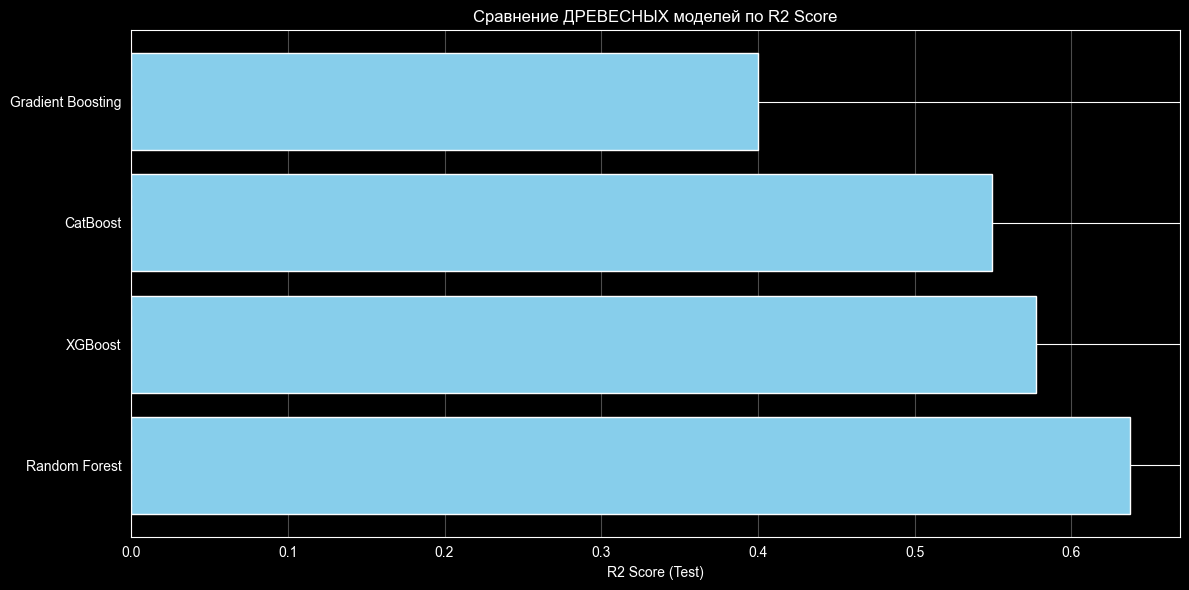

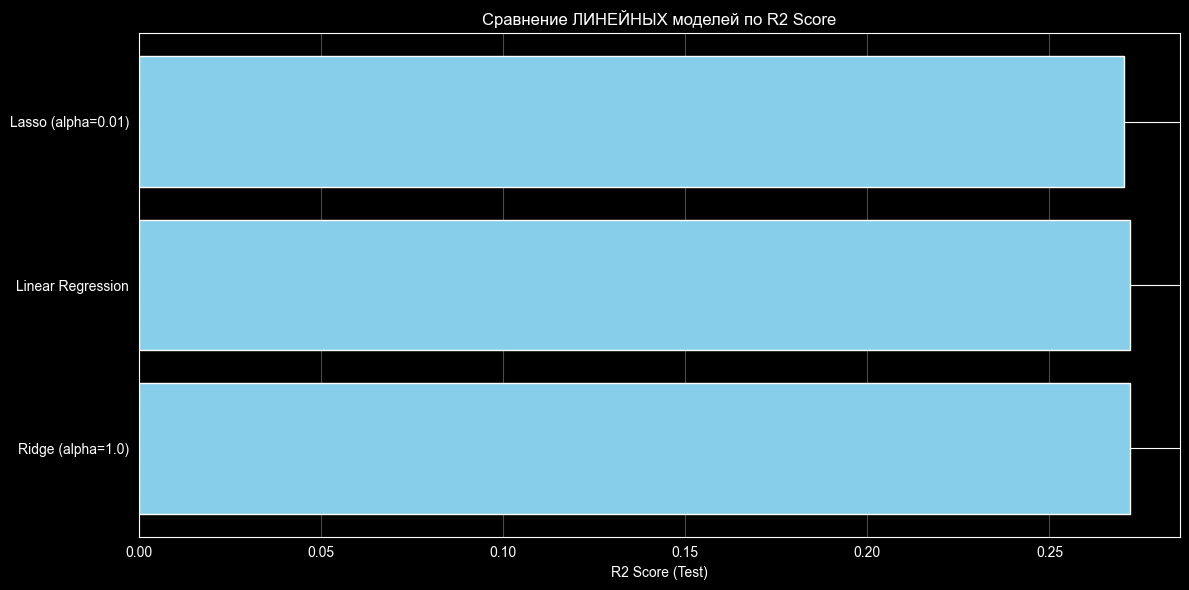

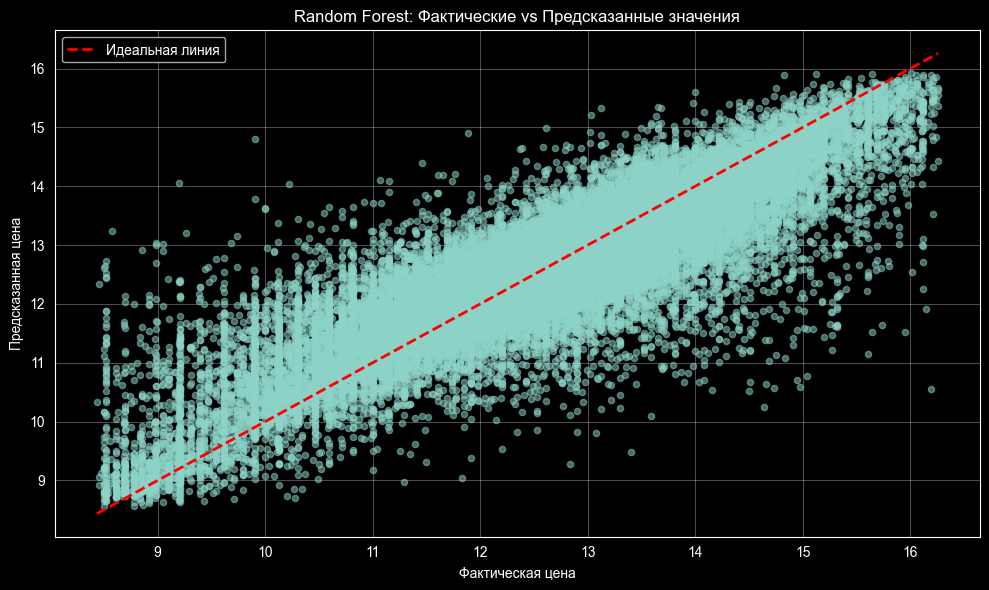

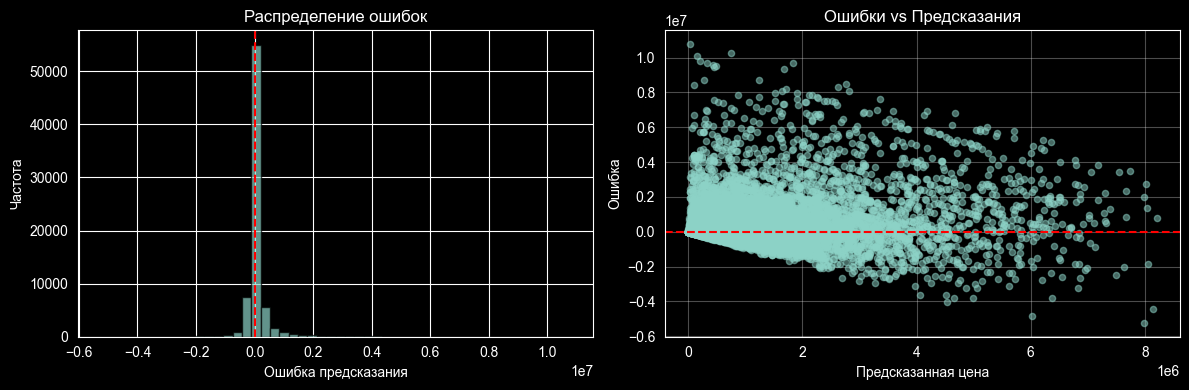

In [129]:
non_linear_df = results_df[~results_df['model'].str.contains('Linear|Ridge|Lasso')]

linear_df = results_df[results_df['model'].str.contains('Linear|Ridge|Lasso')]
# Сравнение R2 scores
plt.figure(figsize=(12, 6))
plt.barh(non_linear_df['model'], non_linear_df['test_r2'], color='skyblue')
plt.xlabel('R2 Score (Test)')
plt.title('Сравнение ДРЕВЕСНЫХ моделей по R2 Score')
plt.axvline(x=0, color='red', linestyle='--', alpha=0.5)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Сравнение R2 scores
plt.figure(figsize=(12, 6))
plt.barh(linear_df['model'], linear_df['test_r2'], color='skyblue')
plt.xlabel('R2 Score (Test)')
plt.title('Сравнение ЛИНЕЙНЫХ моделей по R2 Score')
plt.axvline(x=0, color='red', linestyle='--', alpha=0.5)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Фактические vs Предсказанные значения (для лучшей модели)
best_model_name = results_df.iloc[0]['model']
best_predictions = predictions[best_model_name]

plt.figure(figsize=(10, 6))
plt.scatter(np.log1p(y_test), np.log1p(best_predictions), alpha=0.5, s=20)
plt.plot([np.log1p(y_test).min(), np.log1p(y_test).max()], 
         [np.log1p(y_test).min(), np.log1p(y_test).max()], 
         'r--', lw=2, label='Идеальная линия')
plt.xlabel('Фактическая цена')
plt.ylabel('Предсказанная цена')
plt.title(f'{best_model_name}: Фактические vs Предсказанные значения')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Распределение ошибок
errors = y_test - best_predictions
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(errors, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Ошибка предсказания')
plt.ylabel('Частота')
plt.title('Распределение ошибок')
plt.axvline(x=0, color='red', linestyle='--')

plt.subplot(1, 2, 2)
plt.scatter(best_predictions, errors, alpha=0.5, s=20)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Предсказанная цена')
plt.ylabel('Ошибка')
plt.title('Ошибки vs Предсказания')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

Линейные модели показали себя хуже древесных. Им даже не помогает пункт с колинеарностью.

Как видно в стандартных параметрах у нас есть 3 лидера:

1. Random Forest
2. XGBoost
3. CatBoost

Анализ важности признаков.

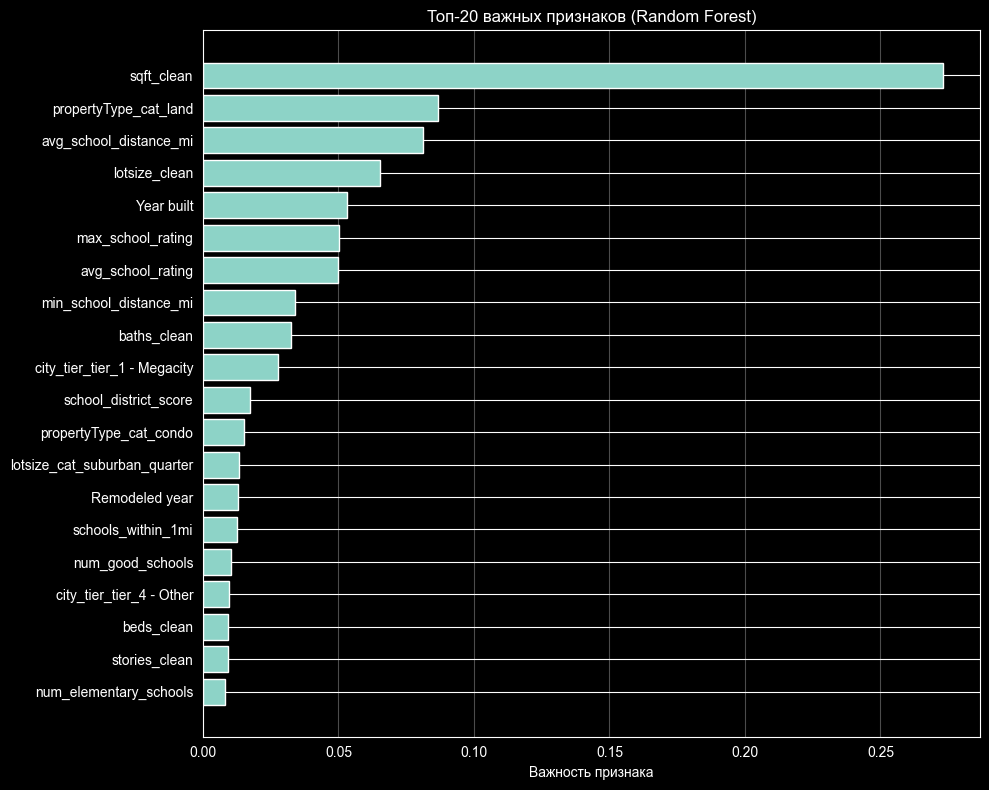


Топ-10 самых важных признаков:
                    feature  importance
                 sqft_clean    0.273081
      propertyType_cat_land    0.086696
     avg_school_distance_mi    0.081044
              lotsize_clean    0.065438
                 Year built    0.053020
          max_school_rating    0.050012
          avg_school_rating    0.049892
     min_school_distance_mi    0.033810
                baths_clean    0.032624
city_tier_tier_1 - Megacity    0.027574


In [130]:
best_model_trained = trained_models[best_model_name]  # реально обученный TTR
tree_model = best_model_trained.regressor_  # достаём внутренний регрессор

if hasattr(tree_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': tree_model.feature_importances_
    }).sort_values('importance', ascending=False)

    plt.figure(figsize=(10, 8))
    plt.barh(feature_importance['feature'].head(20),
             feature_importance['importance'].head(20))
    plt.xlabel('Важность признака')
    plt.title(f'Топ-20 важных признаков ({best_model_name})')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

    print("\nТоп-10 самых важных признаков:")
    print(feature_importance.head(10).to_string(index=False))

Если объединить признаки, то получится, что важными категориями признаков будут:

- Характеристики дома 42.8%
- Школы  18.6% 
- Локация 5.3%
- Участок 5.3%
- Тип недвижимости 3.1%

На эти параметры этих категорий стоит обратить особое внимание, когда будут добавляться новые объявления, чтобы модель выдавала максимально возможное предсказание.

Так же можно ввести удет новые параметры по типу:

- Блиайшая станция метро
- Вид из окна
- Район
- Расстояние от центра

И тогда алгоритм добавит эти столбцы автоматически если появятся новые ключи в словарях признака **homeFacts**.

## Подбор гиперпараметров для лучшей модели.

Подберем гиперпараметры для топ 3 моделей.

In [131]:
# 1. Random Forest
rf_params = {
    'regressor__n_estimators': [700, 800], # Количество деревьев
    'regressor__max_depth': [25, 30], # Максимальная глубина деревьев
    'regressor__min_samples_split': [6, 10], # Минимальное количество образцов для разделения узла
    'regressor__min_samples_leaf': [3, 10], # Минимальное количество образцов в листе
    'regressor__max_features': ['sqrt', 0.3] # Количество признаков для поиска лучшего разделения
}

# 2. XGBoost
xgb_params = {
    'regressor__n_estimators': [730, 800, 1000],
    'regressor__max_depth': [9, 10],
    'regressor__learning_rate': [0.03, 0.3, 0.5], # Скорость обучения
    'regressor__subsample': [0.8, 0.9], # Доля образцов для построения каждого дерева
    'regressor__colsample_bytree': [0.6, 0.7], # Доля признаков для построения каждого дерева
    'regressor__reg_alpha': [0.3, 1], # L1 регуляризация (лассо) - штраф за большие веса
    'regressor__reg_lambda': [3, 4], # L2 регуляризация (ридж) - штраф за квадраты весов
    "regressor__tree_method": ["hist"], # Алгоритм построения деревьев: "hist" - гистограммный
    'regressor__min_child_weight': [15, 20] # мин. сумма весов
}

# 3. Catboost
cb_params = {
    'regressor__n_estimators': [1300, 1500],
    'regressor__learning_rate': [0.07, 0.1],
    'regressor__max_depth': [9, 10],
    'regressor__l2_leaf_reg': [8, 10], # коэффициент L2 - регуляции
    'regressor__bagging_temperature': [0.2, 0.5], # параметр для бейевского бутстрапа
    'regressor__random_strength': [0.01, 0.05] # степень случайности при выборе разделений
}

Функция для подбора параметров и проведения теста с лучшими параметрами.

In [132]:
def tune_large_dataset(model_class, param_grid, model_name, X_train, y_train, n_iter=10, cv=3):

    print(f"\n{'='*50}")
    print(f"Настройка {model_name}...")
    print(f"{'='*50}")
    
    start_time = time.time()
    
    # Размер подвыборки для RandomizedSearch
    max_sample_size = 100_000
    sample_size = min(len(X_train), max_sample_size)

    # Выбираем случайные индексы
    if sample_size < len(X_train):
        indices = np.random.choice(X_train.index, sample_size, replace=False)
        X_sample = X_train.loc[indices]
        y_sample = y_train.loc[indices]
    else:
        X_sample = X_train
        y_sample = y_train

    print(f"Используем выборку: {len(X_sample)} строк из {len(X_train)}")
    
    model_kwargs = {"random_state": 42}

    if "CatBoost" in model_name:
        model_kwargs["thread_count"] = -1
    elif "XGBoost" in model_name or "XGB" in model_name:
        model_kwargs["n_jobs"] = -1
        model_kwargs["verbosity"] = 0
    else:  # RandomForest и прочие sklearn
        model_kwargs["n_jobs"] = -1

    # RandomizedSearch с малым количеством итераций
    search = RandomizedSearchCV(
        TransformedTargetRegressor(
            regressor=model_class(**model_kwargs),
            func=np.log1p,
            inverse_func=np.expm1
        ),
        param_grid,
        n_iter=n_iter,
        cv=cv,
        scoring='r2',
        n_jobs=-1,
        random_state=42,
    )
    
    search.fit(X_sample, y_sample)
    
    print(f"\nЛучшие параметры ({model_name}):")
    for param, value in search.best_params_.items():
        print(f"  {param}: {value}")
    print(f"Лучший R2 (CV): {search.best_score_: .2f}")

    clean_params = {
        k.replace("regressor__", ""): v
        for k, v in search.best_params_.items()
    }

    # Обучаем на всех данных с лучшими параметрами
    print("\nОбучение на полном датасете с лучшими параметрами")
    best_model = TransformedTargetRegressor(
    regressor=model_class(**clean_params, **model_kwargs),
    func=np.log1p,
    inverse_func=np.expm1
    )
    best_model.fit(X_train, y_train)
    
    elapsed = time.time() - start_time
    print(f"Время выполнения: {elapsed: .2f} секунд")
    
    return best_model, search.best_params_

### Подбор параметров Random Forest

In [133]:
tuned_models = {}
best_params = {}

# 1. Random Forest
rf_model, rf_best_params = tune_large_dataset(
    RandomForestRegressor, rf_params, "Random Forest", 
    X_train, y_train, n_iter=8, cv=3
)
tuned_models['rf'] = rf_model
best_params['rf'] = rf_best_params

with open("best_params_rf.json", "w", encoding="utf-8") as f:
    json.dump(rf_best_params, f, indent=4, ensure_ascii=False)


Настройка Random Forest...
Используем выборку: 100000 строк из 296964

Лучшие параметры (Random Forest):
  regressor__n_estimators: 800
  regressor__min_samples_split: 6
  regressor__min_samples_leaf: 3
  regressor__max_features: 0.3
  regressor__max_depth: 30
Лучший R2 (CV):  0.53

Обучение на полном датасете с лучшими параметрами
Время выполнения:  445.35 секунд


### Подбор параметров XGBoost

In [134]:
xgb_model, xgb_best_params = tune_large_dataset(
    XGBRegressor, xgb_params, "XGBoost",
    X_train, y_train, n_iter=8, cv=3
)
tuned_models['xgb'] = xgb_model
best_params['xgb'] = xgb_best_params

with open("best_params_xgb.json", "w", encoding="utf-8") as f:
    json.dump(xgb_best_params, f, indent=4, ensure_ascii=False)


Настройка XGBoost...
Используем выборку: 100000 строк из 296964

Лучшие параметры (XGBoost):
  regressor__tree_method: hist
  regressor__subsample: 0.8
  regressor__reg_lambda: 4
  regressor__reg_alpha: 0.3
  regressor__n_estimators: 800
  regressor__min_child_weight: 15
  regressor__max_depth: 10
  regressor__learning_rate: 0.03
  regressor__colsample_bytree: 0.7
Лучший R2 (CV):  0.60

Обучение на полном датасете с лучшими параметрами
Время выполнения:  69.42 секунд


### Подбор параметров CatBoost

In [135]:
# 3. CatBoost
cb_model, cb_best_params = tune_large_dataset(
    CatBoostRegressor, cb_params, "CatBoost",
    X_train, y_train, n_iter=8, cv=3
)
tuned_models['cb'] = cb_model
best_params['cb'] = cb_best_params

with open("best_params_cb.json", "w", encoding="utf-8") as f:
    json.dump(cb_best_params, f, indent=4, ensure_ascii=False)


Настройка CatBoost...
Используем выборку: 100000 строк из 296964
0:	learn: 1.0640565	total: 16.7ms	remaining: 21.6s
1:	learn: 1.0210621	total: 32.4ms	remaining: 21s
2:	learn: 0.9831920	total: 47.3ms	remaining: 20.4s
3:	learn: 0.9505426	total: 62.9ms	remaining: 20.4s
4:	learn: 0.9226140	total: 77.4ms	remaining: 20s
5:	learn: 0.8967777	total: 92ms	remaining: 19.8s
6:	learn: 0.8750448	total: 107ms	remaining: 19.7s
7:	learn: 0.8553824	total: 122ms	remaining: 19.7s
8:	learn: 0.8382407	total: 137ms	remaining: 19.6s
9:	learn: 0.8230328	total: 152ms	remaining: 19.6s
10:	learn: 0.8090190	total: 168ms	remaining: 19.6s
11:	learn: 0.7964288	total: 183ms	remaining: 19.7s
12:	learn: 0.7853413	total: 198ms	remaining: 19.6s
13:	learn: 0.7752204	total: 214ms	remaining: 19.7s
14:	learn: 0.7664776	total: 229ms	remaining: 19.6s
15:	learn: 0.7578789	total: 244ms	remaining: 19.6s
16:	learn: 0.7498756	total: 259ms	remaining: 19.5s
17:	learn: 0.7427853	total: 274ms	remaining: 19.5s
18:	learn: 0.7360293	total

Сохраним лучшие подобраные параметры моделей.

In [136]:
import json
with open("best_params.json", "w", encoding="utf-8") as f:
    json.dump(best_params, f, indent=4, ensure_ascii=False)

## Выбор лучшей модели

In [137]:
# Создадим таблицу сравнения
results = []

for name, model in tuned_models.items():
    y_pred = model.predict(X_test)
    test_r2 = r2_score(y_test, y_pred)
    test_mae = mean_absolute_error(y_test, y_pred)
    train_r2 = model.score(X_train, y_train)
    
    results.append({
        'model': name,
        'test_r2': test_r2,
        'test_mae': test_mae,
        'test_rmse': np.sqrt(test_r2),
        'overfit_gap': train_r2 - test_r2
    })

# Вывод результатов
results_df = pd.DataFrame(results)
print("\n" + "="*60)
print("РЕЗУЛЬТАТЫ НАСТРОЕННЫХ МОДЕЛЕЙ НА ТЕСТОВОЙ ВЫБОРКЕ")
print("="*60)
print(results_df.sort_values('test_r2', ascending=False).to_string())

# Лучшая модель
best_model_name = results_df.loc[results_df['test_r2'].idxmax(), 'model']
print(f"\nЛУЧШАЯ МОДЕЛЬ: {best_model_name}")


РЕЗУЛЬТАТЫ НАСТРОЕННЫХ МОДЕЛЕЙ НА ТЕСТОВОЙ ВЫБОРКЕ
  model   test_r2       test_mae  test_rmse  overfit_gap
2    cb  0.655953  191940.275228   0.809909     0.063451
1   xgb  0.653432  193648.125000   0.808351     0.067273
0    rf  0.609131  200770.103298   0.780468     0.138268

ЛУЧШАЯ МОДЕЛЬ: cb


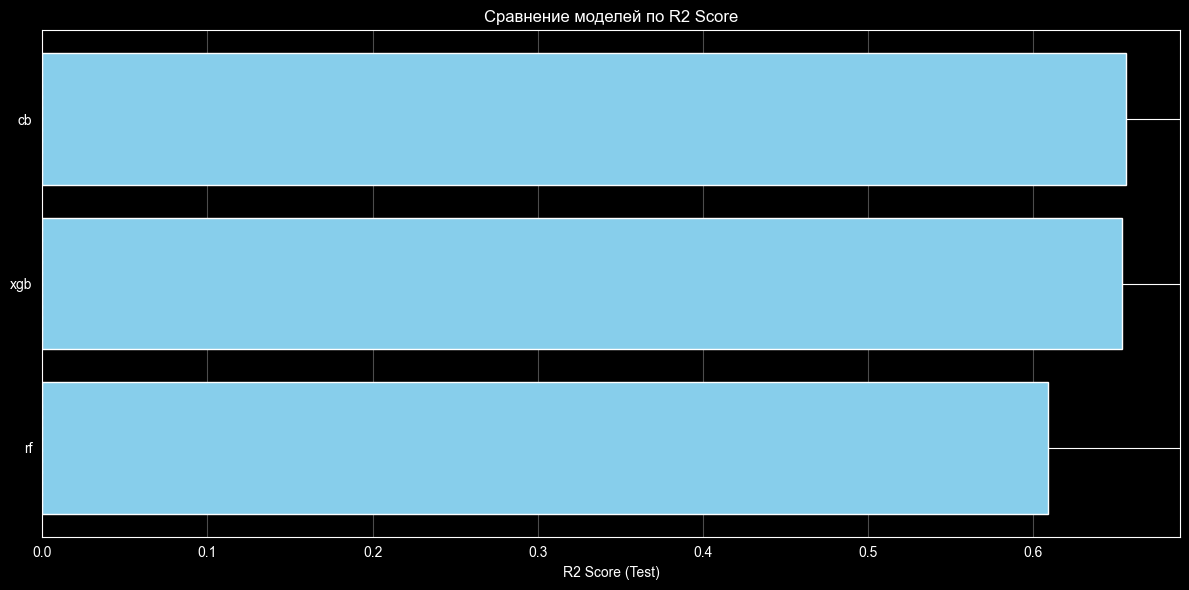

In [138]:
# Сравнение R2 scores
plt.figure(figsize=(12, 6))
plt.barh(results_df['model'], results_df['test_r2'], color='skyblue')
plt.xlabel('R2 Score (Test)')
plt.title('Сравнение моделей по R2 Score')
plt.axvline(x=0, color='red', linestyle='--', alpha=0.5)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

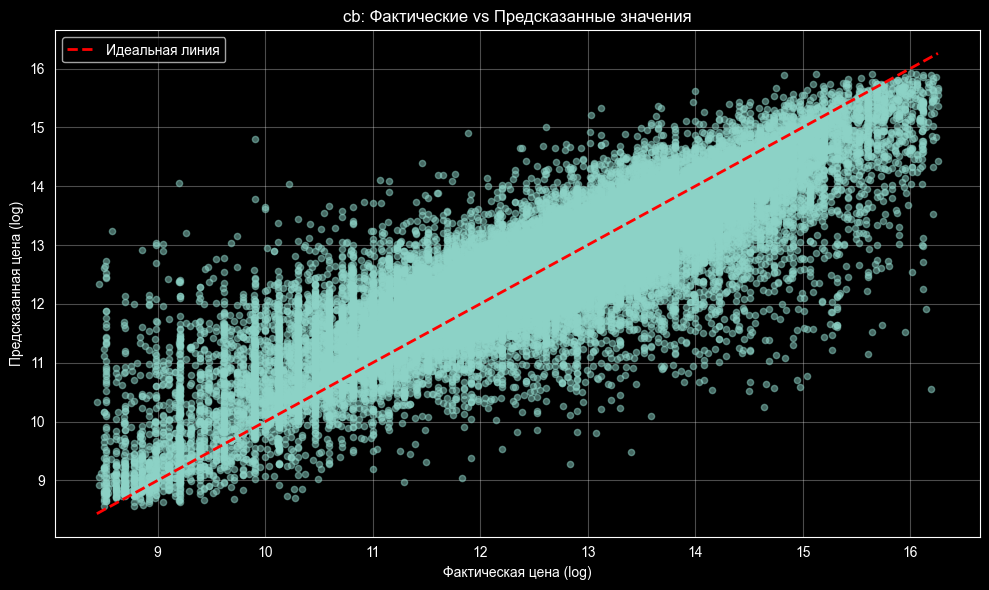

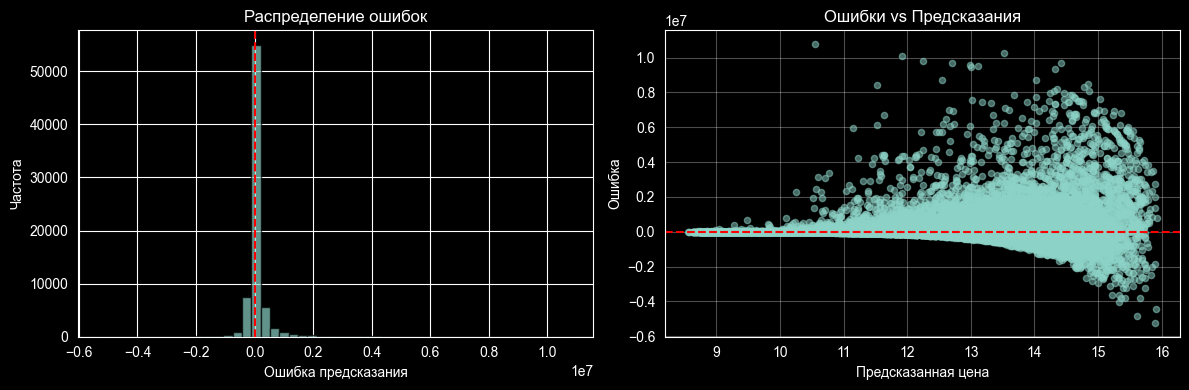

In [139]:

# Фактические vs Предсказанные значения (для лучшей модели)

plt.figure(figsize=(10, 6))
plt.scatter(np.log1p(y_test), np.log1p(best_predictions), alpha=0.5, s=20)
lims = [
    np.log1p(min(y_test.min(), best_predictions.min())),
    np.log1p(max(y_test.max(), best_predictions.max()))
]
plt.plot(lims, lims, 'r--', lw=2, label='Идеальная линия')
plt.xlabel('Фактическая цена (log)')
plt.ylabel('Предсказанная цена (log)')
plt.title(f'{best_model_name}: Фактические vs Предсказанные значения')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Распределение ошибок
errors = y_test - best_predictions
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(errors, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Ошибка предсказания')
plt.ylabel('Частота')
plt.title('Распределение ошибок')
plt.axvline(x=0, color='red', linestyle='--')

plt.subplot(1, 2, 2)
plt.scatter(np.log1p(best_predictions), errors, alpha=0.5, s=20)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Предсказанная цена')
plt.ylabel('Ошибка')
plt.title('Ошибки vs Предсказания')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

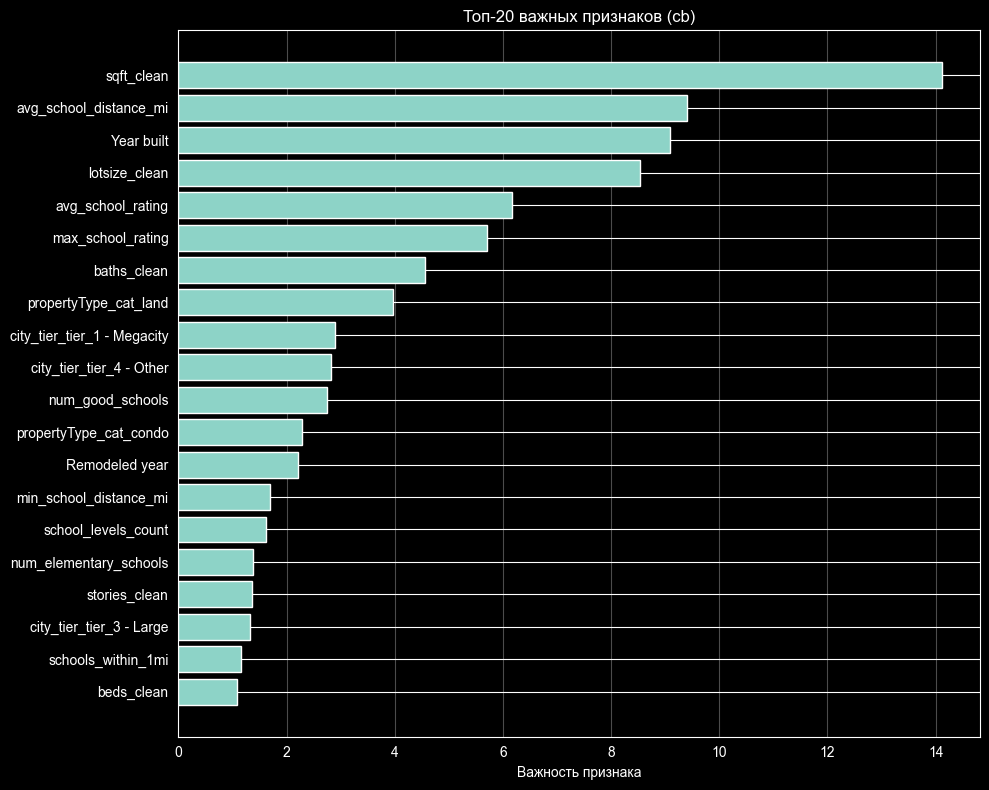


Топ-10 самых важных признаков:
                    feature  importance
                 sqft_clean   14.113798
     avg_school_distance_mi    9.401667
                 Year built    9.087373
              lotsize_clean    8.539411
          avg_school_rating    6.164228
          max_school_rating    5.704683
                baths_clean    4.562228
      propertyType_cat_land    3.961601
city_tier_tier_1 - Megacity    2.902125
   city_tier_tier_4 - Other    2.821652


In [140]:
best_model_trained = tuned_models[best_model_name]
tree_model = best_model_trained.regressor_

if "CatBoost" in best_model_name:
    importances = tree_model.get_feature_importance()
else:
    importances = tree_model.feature_importances_

feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importances
}).sort_values('importance', ascending=False)

# График топ-20
top_features = feature_importance.head(20)
plt.figure(figsize=(10, 8))
plt.barh(top_features['feature'], top_features['importance'])
plt.xlabel('Важность признака')
plt.title(f'Топ-20 важных признаков ({best_model_name})')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Таблица топ-10
print("\nТоп-10 самых важных признаков:")
print(feature_importance.head(10).to_string(index=False))


После подборки параметров ситуация изменилась. Лучше моделью по метрики *R2* теперь является *CatBoost*, а вот после того как *RandomForest* избавился от переобучения он сильно сдал позиции лидера и стал третьим. В целом *CatBoost* лучше работает с категориальными признаками, быстрее обучается, можно запускать его обучение на видеокарте, что может значительно ускорить процесс и добиться лучших результатов обучения если добавить подбор параметров через *Optuna* то там можно добиться лучшей метрики на обучаемой выборке. Мне пришлось выполнять проект на ноутбуке без видеокарты поэтому сильно не углублялся в подбор параметров.

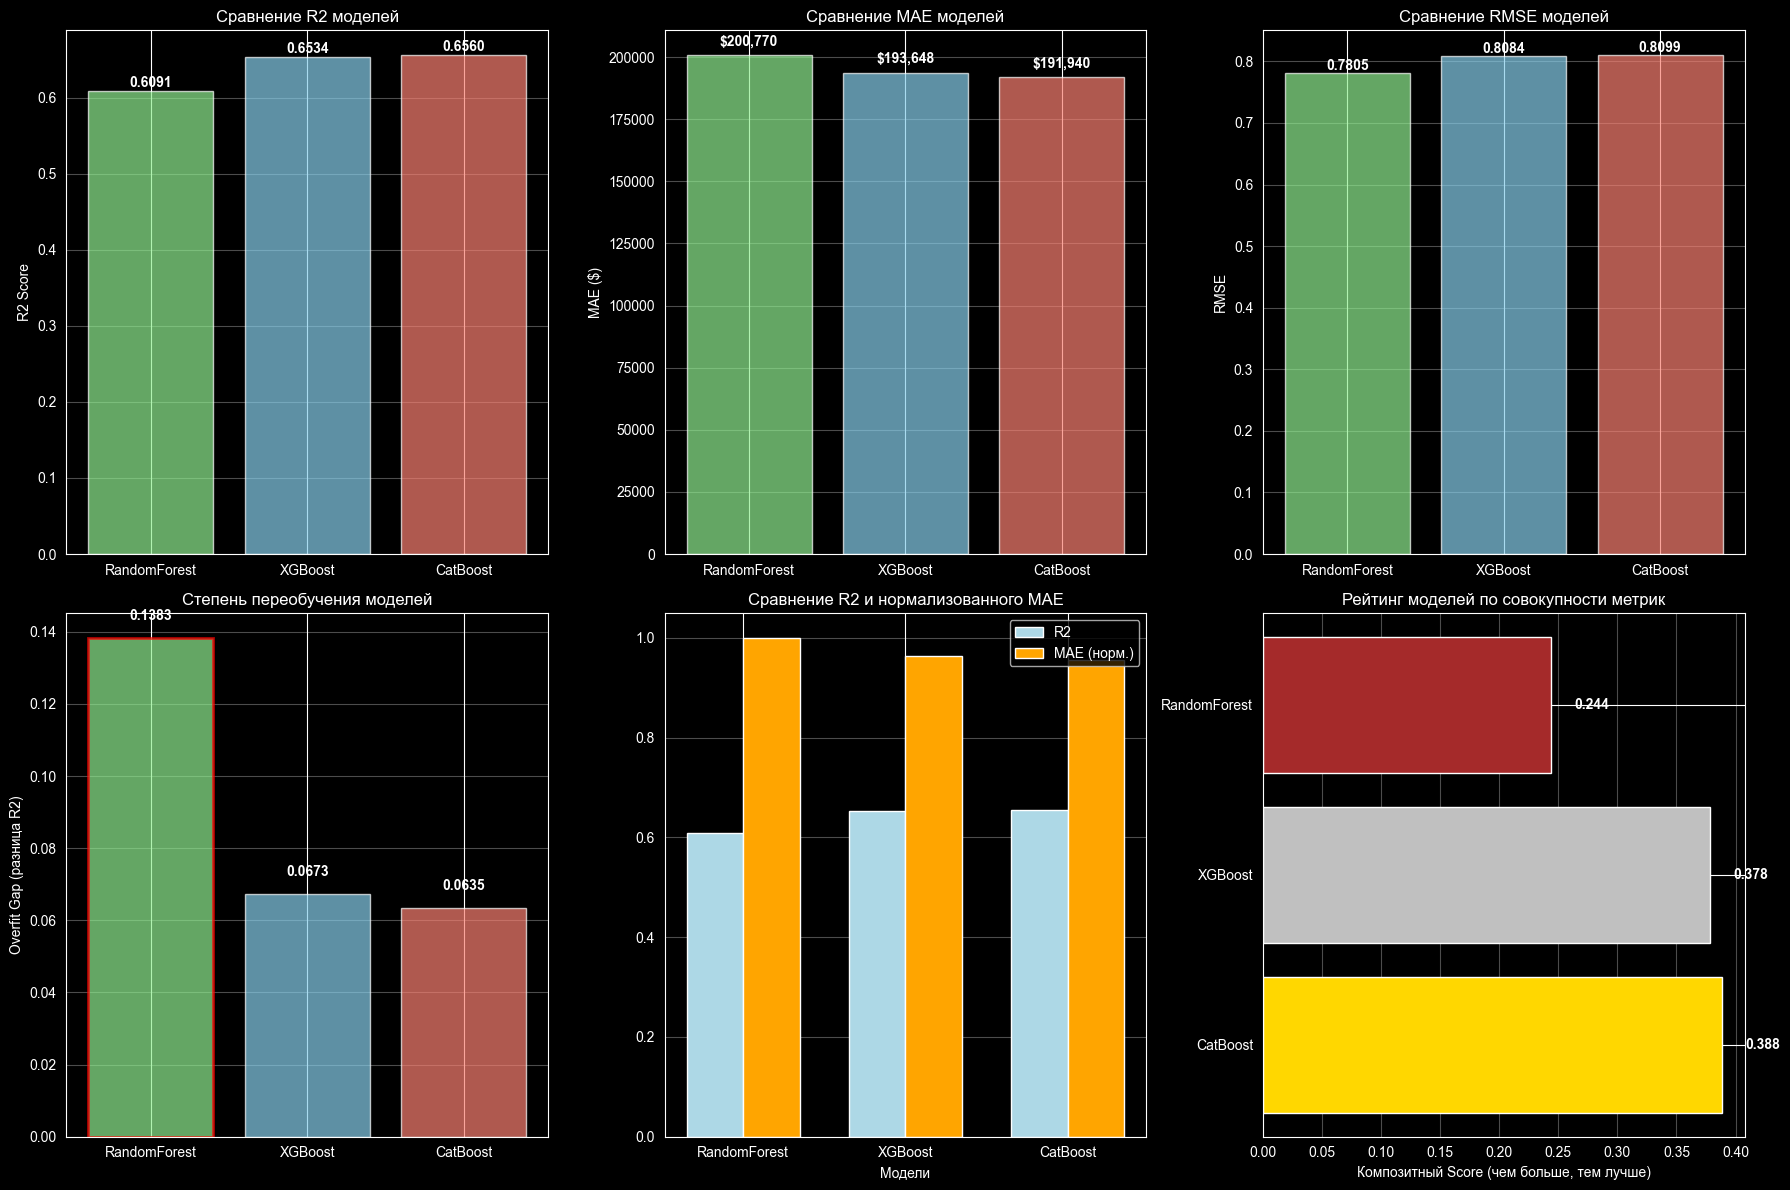

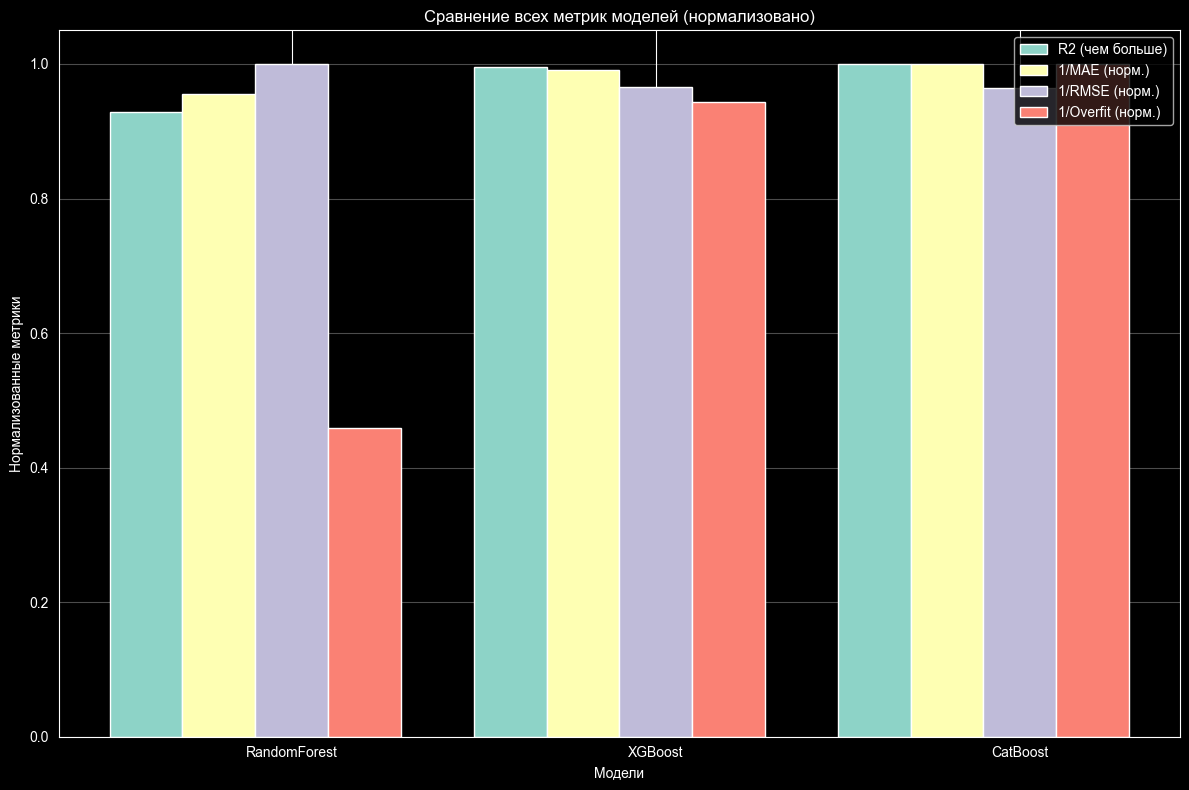

ИТОГОВОЕ СРАВНЕНИЕ МОДЕЛЕЙ
Модель          R2         MAE ($)         RMSE       Overfit Gap 
--------------------------------------------------------------------------------
RandomForest    0.6091     $200,770        0.7805     0.1383      
XGBoost         0.6534     $193,648        0.8084     0.0673      
CatBoost        0.6560     $191,940        0.8099     0.0635      
--------------------------------------------------------------------------------
Лучшая R2: CatBoost (0.6560)
Лучшая MAE: CatBoost ($191,940)
Наименьшее переобучение: CatBoost (0.0635)


In [147]:
model_data = {
    'rf': {'r2': 0.609131, 'mae': 200770.103298, 'rmse': 0.780468, 'overfit_gap': 0.138268},
    'xgb': {'r2': 0.653432, 'mae': 193648.125000, 'rmse': 0.808351, 'overfit_gap': 0.067273},
    'cb': {'r2': 0.655953, 'mae': 191940.275228, 'rmse': 0.809909, 'overfit_gap': 0.063451}
}

# Порядок моделей для отображения
models = ['rf', 'xgb', 'cb']
model_names = ['RandomForest', 'XGBoost', 'CatBoost']
colors = ['lightgreen', 'skyblue', 'salmon']

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Сравниваю R2
r2_scores = [model_data[model]['r2'] for model in models]

axes[0, 0].bar(model_names, r2_scores, color=colors, alpha=0.7)
axes[0, 0].set_ylabel('R2 Score')
axes[0, 0].set_title('Сравнение R2 моделей')
axes[0, 0].grid(axis='y', alpha=0.3)

# Добавляю значения
for i, (name, r2) in enumerate(zip(model_names, r2_scores)):
    axes[0, 0].text(i, r2 + 0.005, f'{r2:.4f}', ha='center', fontweight='bold')

# 2. Сравниваю MAE
mae_scores = [model_data[model]['mae'] for model in models]

axes[0, 1].bar(model_names, mae_scores, color=colors, alpha=0.7)
axes[0, 1].set_ylabel('MAE ($)')
axes[0, 1].set_title('Сравнение MAE моделей')
axes[0, 1].grid(axis='y', alpha=0.3)

# Добавляю значения
for i, (name, mae) in enumerate(zip(model_names, mae_scores)):
    axes[0, 1].text(i, mae + max(mae_scores)*0.02, f'${mae:,.0f}', ha='center', fontweight='bold')

# 3. Сравниваю RMSE
rmse_scores = [model_data[model]['rmse'] for model in models]

axes[0, 2].bar(model_names, rmse_scores, color=colors, alpha=0.7)
axes[0, 2].set_ylabel('RMSE')
axes[0, 2].set_title('Сравнение RMSE моделей')
axes[0, 2].grid(axis='y', alpha=0.3)

# Добавляю значения
for i, (name, rmse) in enumerate(zip(model_names, rmse_scores)):
    axes[0, 2].text(i, rmse + 0.005, f'{rmse:.4f}', ha='center', fontweight='bold')

# 4. Overfit Gap (разница между train и test)
overfit_gaps = [model_data[model]['overfit_gap'] for model in models]

axes[1, 0].bar(model_names, overfit_gaps, color=colors, alpha=0.7)
axes[1, 0].set_ylabel('Overfit Gap (разница R2)')
axes[1, 0].set_title('Степень переобучения моделей')
axes[1, 0].grid(axis='y', alpha=0.3)

# Добавляю значения
for i, (name, gap) in enumerate(zip(model_names, overfit_gaps)):
    axes[1, 0].text(i, gap + 0.005, f'{gap:.4f}', ha='center', fontweight='bold')
    # Подсветка самой переобученной модели
    if gap == max(overfit_gaps):
        axes[1, 0].get_children()[i].set_edgecolor('red')
        axes[1, 0].get_children()[i].set_linewidth(2)

# 5. Комбинированный график R2 и MAE (для лучшего сравнения)
x = np.arange(len(model_names))
width = 0.35

# Нормализую MAE для отображения на одном графике с R2
mae_normalized = [mae / max(mae_scores) for mae in mae_scores]

rects1 = axes[1, 1].bar(x - width/2, r2_scores, width, label='R2', color='lightblue')
rects2 = axes[1, 1].bar(x + width/2, mae_normalized, width, label='MAE (норм.)', color='orange')
axes[1, 1].set_xlabel('Модели')
axes[1, 1].set_title('Сравнение R2 и нормализованного MAE')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(model_names)
axes[1, 1].legend()
axes[1, 1].grid(axis='y', alpha=0.3)

# 6. Рейтинг моделей по совокупности метрик
# Создаю комплексную оценку
# Нормализую метрики
norm_r2 = [1 - r2 for r2 in r2_scores]  # Инвертируем R2
norm_mae = [mae / max(mae_scores) for mae in mae_scores]
norm_overfit = [gap / max(overfit_gaps) for gap in overfit_gaps]

# Взвешенная сумма
weights = {'r2': 0.4, 'mae': 0.4, 'overfit': 0.2}
composite_scores = []
for i in range(len(models)):
    score = (norm_r2[i] * weights['r2'] +
             norm_mae[i] * weights['mae'] +
             norm_overfit[i] * weights['overfit'])
    composite_scores.append(score)

# Инвертирую
composite_scores = [1 - score for score in composite_scores]

# Сортирую модели по composite score
sorted_indices = np.argsort(composite_scores)[::-1]
sorted_models = [model_names[i] for i in sorted_indices]
sorted_scores = [composite_scores[i] for i in sorted_indices]

axes[1, 2].barh(sorted_models, sorted_scores, color=['gold', 'silver', 'brown'])
axes[1, 2].set_xlabel('Композитный Score (чем больше, тем лучше)')
axes[1, 2].set_title('Рейтинг моделей по совокупности метрик')
axes[1, 2].grid(axis='x', alpha=0.3)

# Добавляю значения
for i, (name, score) in enumerate(zip(sorted_models, sorted_scores)):
    axes[1, 2].text(score + 0.02, i, f'{score:.3f}', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Дополнительный график: сравнение всех метрик в одном
fig, ax = plt.subplots(figsize=(12, 8))

x = np.arange(len(model_names))
width = 0.2

# Нормализую все метрики для сравнения
metrics_to_compare = ['R2 (чем больше)', '1/MAE (норм.)', '1/RMSE (норм.)', '1/Overfit (норм.)']
norm_metrics = [
    r2_scores,  # R2 уже в норм. виде
    [1/(mae/max(mae_scores)) for mae in mae_scores],  # Инвертируем MAE
    [1/rmse for rmse in rmse_scores],  # Инвертируем RMSE
    [1/(gap/max(overfit_gaps)) for gap in overfit_gaps]  # Инвертируем overfit
]

# Нормализую все от 0 до 1 для сравнения
norm_metrics = [np.array(m) / np.max(m) for m in norm_metrics]

for i, (metric_name, metric_values) in enumerate(zip(metrics_to_compare, norm_metrics)):
    offset = width * (i - len(metrics_to_compare)/2)
    ax.bar(x + offset, metric_values, width, label=metric_name)

ax.set_xlabel('Модели')
ax.set_ylabel('Нормализованные метрики')
ax.set_title('Сравнение всех метрик моделей (нормализовано)')
ax.set_xticks(x)
ax.set_xticklabels(model_names)
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Вывод итоговой таблицы
print("="*80)
print("ИТОГОВОЕ СРАВНЕНИЕ МОДЕЛЕЙ")
print("="*80)
print(f"{'Модель':<15} {'R2':<10} {'MAE ($)':<15} {'RMSE':<10} {'Overfit Gap':<12}")
print("-"*80)

for model, name in zip(models, model_names):
    data = model_data[model]
    print(f"{name:<15} {data['r2']:<10.4f} ${data['mae']:<14,.0f} {data['rmse']:<10.4f} {data['overfit_gap']:<12.4f}")

print("-"*80)
print(f"Лучшая R2: {model_names[np.argmax(r2_scores)]} ({max(r2_scores):.4f})")
print(f"Лучшая MAE: {model_names[np.argmin(mae_scores)]} (${min(mae_scores):,.0f})")
print(f"Наименьшее переобучение: {model_names[np.argmin(overfit_gaps)]} ({min(overfit_gaps):.4f})")
print("="*80)

## Итог

После проделанной работы по выбору модели. Я решил остановиться на CatBoost так как она показала большую метрику _R2_ и _MAE_.

# Часть 3. Подготовка модели к продакшену.

Дальше буду объединять ячейки из первой части и получу функцию для обработки сырых данных на входе.


In [142]:
# def _do_preprocessing(df):
#     df = df.copy()
#
#     # Сбрасываю индексы в начале
#     df = df.reset_index(drop=True)
#
#     # Удаляю ненужные модели параметры
#     df.drop(['mls-id', 'MlsId'], axis=1, inplace=True)
#
#     # Объединю private pool и PrivatePool
#     df['pool'] = df['PrivatePool'].combine_first(df['private pool'])
#     df['pool'] = df['pool'].fillna('no').str.lower().str.strip().eq('yes')
#
#     # Удалю старые признаки с бассейном
#     df.drop(['PrivatePool', 'private pool'], axis=1, inplace=True)
#
#     # Разметка сокращенных статусов
#     short_status_map = {
#         "C": "Continue Show",
#         "P": "Pending Sale",
#         "U": "Under Contract"
#     }
#
#     def normalize_status(s):
#         """Нормальзую признак статуса"""
#
#         if pd.isna(s):
#             return "missing"
#
#         if s in short_status_map:
#             return short_status_map[s]
#
#         s = s.lower()
#
#         if "missing" in s:
#             return "missing"
#
#         if "active" in s or "for sale" in s or "continue show" in s:
#             return "active"
#
#         if "pending" in s or "contract" in s or "option" in s:
#             return "pending/under Contract"
#
#         if "contingent" in s:
#             return "contingent"
#
#         if "auction" in s or "foreclos" in s or "pre-fore" in s:
#             return "auction/foreclosure"
#
#         if "new" in s or "coming" in s or "extended" in s or "price change" in s or "back on market" in s:
#             return "new/coming Soon"
#
#         if "sold" in s or "closed" in s:
#             return "sold"
#
#         if "rent" in s:
#             return "rent"
#
#         return "other"
#
#     # Применяю
#     df["status_cat"] = df["status"].apply(normalize_status)
#
#
#     def normalize_property_type(s):
#         """Нормализую признак типа постройки"""
#
#         if pd.isna(s):
#             return "Missing"
#         s = s.lower().strip()
#
#         if "missing" in s or s == "":
#             return "Missing"
#
#         # Single Family (самая широкая группа)
#         if "single" in s or "detached" in s or "story" in s:
#             return "single Family"
#         if "traditional" in s or "colonial" in s or "craftsman" in s:
#             return "single Family"
#         if "ranch" in s or "bungalow" in s or "cape cod" in s:
#             return "single Family"
#         if "contemporary" in s or "modern" in s or "transitional" in s:
#             return "single Family"
#
#         # Condo
#         if "condo" in s:
#             return "condo"
#
#         # Townhouse
#         if "town" in s or "row home" in s:
#             return "townhouse"
#
#         # Multi-family
#         if "multi" in s or "multiple occupancy" in s:
#             return "multi-family"
#
#         # Land
#         if "land" in s or "lot" in s:
#             return "land"
#
#         # Apartment / Co-op
#         if "apart" in s or "coop" in s or "cooperative" in s or "high rise" in s:
#             return "apartment/co-Op"
#
#         # Mobile
#         if "mobile" in s or "manufact" in s or "mfd" in s:
#             return "mobile/manufactured"
#
#         # Farm
#         if "farm" in s or "ranch" in s:
#             return "farm/ranch"
#
#         return "other"
#
#     # Применяю
#     df["propertyType_cat"] = df["propertyType"].apply(normalize_property_type)
#
#     # Список значений, которые считаем как «неизвестный адрес»
#     undisclosed = ["MISSING", "Address Not Disclosed", "Undisclosed Address",
#                    "(undisclosed Address)", "Address Not Available", "Unknown Address"]
#
#     def normalize_street(s):
#         """Нормальзую признак улицы"""
#
#         if pd.isna(s) or s in undisclosed:
#             return "undisclosed"
#         else:
#             return "known"
#
#     # Применяю
#     df["street"] = df["street"].fillna("MISSING")
#
#     df["street_cat"] = df["street"].apply(normalize_street)
#
#     # Вычисляю моду среди нормальных значений (1–10)
#     valid_baths = df["baths"].apply(lambda x: re.search(r"(\d+(\.\d+)?)", str(x).replace(",", "")))
#     valid_baths = valid_baths[valid_baths.notnull()].apply(lambda m: float(m.group(1)))
#     valid_baths = valid_baths[(valid_baths >= 1) & (valid_baths <= 10)]
#     mode_baths = Counter(valid_baths).most_common(1)[0][0]
#
#     def clean_baths(x, mode_val):
#         """Очищаю признак кол-ва ван"""
#
#         if pd.isna(x) or str(x).strip().lower() in ["missing", ""]:
#             return 0
#         x_str = str(x).lower().strip()
#         match = re.search(r"(\d+(\.\d+)?)", x_str.replace(",", "."))
#         if match:
#             val = float(match.group(1))
#             if val > 10:
#                 return mode_val
#             return val
#         return mode_val
#
#     # Применяю
#     df["baths_clean"] = df["baths"].apply(lambda x: clean_baths(x, mode_baths))
#
#     def extract_home_facts(x):
#         """Преобразую значение признака"""
#
#         def clean_value(v):
#
#             if v in [None, '', '—', 'No Data']:
#                 return 0
#
#             # Если это строка: убираю пробелы и мусор
#             if isinstance(v, str):
#                 v = v.strip()
#                 # Оставляю только цифры, если это похоже на число
#                 v_digits = re.sub(r'[^0-9]', '', v)
#                 if v_digits.isdigit():
#                     return int(v_digits)
#                 return v  # Если нет цифр — оставить как есть (категориальное значение)
#
#             return v  # Числа вернуть как есть
#
#         result = {}
#         try:
#             data_list = ast.literal_eval(x)
#             for fact in data_list.get('atAGlanceFacts', []):
#                 val = clean_value(fact.get('factValue'))
#                 label = fact.get('factLabel')
#                 result[label] = val
#
#         except:
#             result = {
#                 'Year built': 0,
#                 'Remodeled year': 0,
#                 'Heating': 0,
#                 'Cooling': 0,
#                 'Parking': 0,
#                 'lotsize': 0,
#                 'Price/Sqft': 0
#             }
#
#         return result
#
#     # Применяю и разворачиваю в отдельные колонки
#     home_facts_df = df['homeFacts'].apply(extract_home_facts).apply(pd.Series)
#
#     home_facts_df.index = df.index
#     # Объединяю с основным датафреймом
#     df = pd.concat([df, home_facts_df], axis=1)
#
#     df['Heating'] = df['Heating'].fillna('').astype(str)
#     df['Heating'] = df['Heating'].str.replace(',', '', regex=False).str.lower()
#     df['Heating'] = df['Heating'].str.strip()
#
#     def categorize_heating(value):
#         """Категоризирую признак отопления"""
#
#         if pd.isna(value) or value == 'missing':
#             return 'Missing'
#
#         text = str(value).lower()
#
#         # Основные 10 категорий
#         if 'forced air' in text or 'forcedair' in text:
#             return 'forced air'
#
#         if 'heat pump' in text:
#             return 'heatpump'
#
#         if 'central' in text:
#             return 'central'
#
#         if 'electric' in text:
#             return 'electric'
#
#         if 'gas' in text or 'natural' in text:
#             return 'gas'
#
#         if 'baseboard' in text:
#             return 'baseboard'
#
#         if 'wall' in text and 'window' not in text:
#             return 'wall heater'
#
#         if 'radiant' in text or 'hot water' in text or 'steam' in text:
#             return 'radiant/water'
#
#         if text == 'other':
#             return 'other'
#
#         if 'none' in text or 'no cooling' in text:
#             return 'none'
#
#         return 'other'
#
#     # Применяю
#     df["heating_cat"] = df["Heating"].apply(categorize_heating)
#
#     def categorize_cooling(value):
#         """Категоризирую охлаждение"""
#
#         if pd.isna(value) or value == 'missing' or str(value) == '0':
#             return 'Missing'
#
#         text = str(value).lower()
#
#         # Основные категории охлаждения
#         if 'central air' in text or 'central a/c' in text or 'air conditioning-central' in text:
#             return 'central air'
#
#         if 'central' in text and ('cooling' not in text and 'electric' not in text and 'gas' not in text):
#             return 'central'
#
#         if 'refrigeration' in text:
#             return 'refrigeration'
#
#         if 'evaporative' in text or 'swamp' in text:
#             return 'evaporative'
#
#         if 'heat pump' in text:
#             return 'heat pump'
#
#         if 'window' in text or 'wall/window' in text or 'wall unit' in text:
#             return 'window/wall unit'
#
#         if 'electric' in text:
#             return 'electric'
#
#         if 'gas' in text:
#             return 'gas'
#
#         if 'none' in text or 'no heating' in text:
#             return 'none'
#
#         if 'other' in text:
#             return 'other'
#
#         if 'has cooling' in text or 'cooling system' in text:
#             return 'has cooling'
#
#         # Цифры и мусор
#         if text in ['1', '2', '3', '90', 'has heating']:
#             return 'other'
#
#         # Всё остальное
#         return 'other'
#
#     # Применяю
#     df['cooling_cat'] = df['Cooling'].apply(categorize_cooling)
#
#     # Применяю
#     def categorize_parking(value):
#         """Категоризируем парковку"""
#
#         if pd.isna(value) or str(value) == '0':
#             return 'Missing'
#
#         text = str(value).lower()
#
#         # Основные типы парковки
#         if 'attached garage' in text or 'garage-attached' in text or 'garage attached' in text:
#             return 'attached garage'
#
#         if 'detached garage' in text or 'detached parking' in text:
#             return 'detached garage'
#
#         if 'carport' in text:
#             return 'carport'
#
#         if 'off street' in text or 'offstreet' in text:
#             return 'off street'
#
#         if 'on street' in text or 'onstreet' in text:
#             return 'on street'
#
#         if 'driveway' in text:
#             return 'driveway'
#
#         if 'none' in text:
#             return 'none'
#
#         if text.isdigit():
#             num = int(text)
#             if num <= 0:
#                 return 'missing'
#             elif num == 1:
#                 return '1 Space'
#             elif num == 2:
#                 return '2 Spaces'
#             elif num == 3:
#                 return '3 Spaces'
#             elif num <= 6:
#                 return '4-6 Spaces'
#             else:
#                 return '7+ Spaces'
#
#         if 'parking' in text and ('desc' in text or 'type' in text or 'yn' in text):
#             return 'Other Parking'
#
#         # Всё остальное
#         return 'other'
#
#     # Применяю
#     df['parking_cat'] = df['Parking'].apply(categorize_parking)
#
#     def clean_lotsize(x):
#         """Очищаю признак размера участка"""
#
#         if pd.isna(x) or str(x).lower() in ["missing", "no data", "(other)"]:
#             return 0
#         x_str = str(x).lower().replace(",", "").strip()
#         if "acre" in x_str:
#             match = re.search(r"([\d\.]+)", x_str)
#             if match:
#                 return int(float(match.group(1)) * 43560)
#         elif "sqft" in x_str or "sq. ft." in x_str:
#             match = re.search(r"([\d\.]+)", x_str)
#             if match:
#                 return float(match.group(1))
#         else:
#             match = re.search(r"([\d\.]+)", x_str)
#             if match:
#                 return float(match.group(1))
#         return 0
#
#     # Применяю
#     df["lotsize_clean"] = df["lotsize"].apply(clean_lotsize)
#
#     def categorize_lotsize(x):
#         """Категоризирую очищенный размер участка"""
#         if pd.isna(x):
#             return "missing"
#         elif x < 1500:
#             return "urban_condo"
#         elif x < 3000:
#             return "urban_rowhouse"
#         elif x < 5000:
#             return "urban_small_lot"
#         elif x < 7500:
#             return "urban_standard"
#         elif x < 10000:
#             return "suburban_small"
#         elif x < 21780:
#             return "suburban_quarter"
#         elif x < 43560:
#             return "suburban_half"
#         elif x < 108900:
#             return "suburban_full"
#         elif x < 217800:
#             return "rural_small"
#         else:
#             return "rural_large"
#
#     # Применяю
#     df["lotsize_cat"] = df["lotsize_clean"].apply(categorize_lotsize)
#
#     def parse_schools(schools_str):
#         """Меняю значение признака школы"""
#
#         if pd.isna(schools_str) or schools_str == '':
#             return []
#
#         # Если уже список
#         if isinstance(schools_str, list):
#             return schools_str
#
#         # Пробую разные методы парсинга
#         try:
#             # Метод 1: ast.literal_eval
#             parsed = ast.literal_eval(str(schools_str))
#             if isinstance(parsed, list):
#                 return parsed
#         except:
#             try:
#                 # Метод 2: json с заменой None
#                 json_str = str(schools_str).replace("'", '"').replace('None', 'null')
#                 parsed = json.loads(json_str)
#                 if isinstance(parsed, list):
#                     return parsed
#             except:
#                 pass
#
#         return []
#
#     # Применяю
#     df['schools_parsed'] = df['schools'].apply(parse_schools)
#
#     def extract_numeric_ratings(schools_list):
#         """Извлекаю рейтинг школ"""
#
#         if not isinstance(schools_list, list):
#             return []
#
#         numeric_ratings = []
#
#         for school in schools_list:
#             if not isinstance(school, dict):
#                 continue
#
#             ratings = school.get('rating', [])
#             if not isinstance(ratings, list):
#                 continue
#
#             for rating_str in ratings:
#                 if not isinstance(rating_str, str):
#                     continue
#
#                 # NR → 0
#                 if rating_str.strip().upper() == "NR":
#                     numeric_ratings.append(0)
#                     continue
#
#                 # Берём первое число
#                 match = re.search(r'\d+', rating_str)
#                 if match:
#                     try:
#                         numeric_ratings.append(int(match.group()))
#                     except:
#                         pass
#
#         return numeric_ratings
#
#     # Применяю и создаю признаки
#     df['school_ratings_list'] = df['schools_parsed'].apply(extract_numeric_ratings)
#
#     # Средний рейтинг
#     df['avg_school_rating'] = df['school_ratings_list'].apply(
#         lambda x: round(np.mean(x), 2) if x else 0
#     )
#
#     # Максимальный рейтинг
#     df['max_school_rating'] = df['school_ratings_list'].apply(
#         lambda x: max(x) if x else 0
#     )
#
#     # Количество школ с рейтингом >= 7/10
#     df['num_good_schools'] = df['school_ratings_list'].apply(
#         lambda x: sum(1 for r in x if r >= 7) if x else 0
#     )
#
#     def extract_distances(schools_list):
#         """Извлекаю расстояние до школ"""
#
#         if not isinstance(schools_list, list):
#             return []
#
#         distances = []
#         for school in schools_list:
#             if isinstance(school, dict):
#                 data_dict = school.get('data', {})
#                 if isinstance(data_dict, dict):
#                     dist_list = data_dict.get('Distance', [])
#                     if isinstance(dist_list, list):
#                         for dist_str in dist_list:
#                             if dist_str and isinstance(dist_str, str):
#                                 # Ищем число перед 'mi'
#                                 match = re.search(r'(\d+\.?\d*)', dist_str)
#                                 if match:
#                                     try:
#                                         distances.append(float(match.group(1)))
#                                     except:
#                                         pass
#
#         return distances
#
#     # Применяю и создаю признаки
#     df['school_distances'] = df['schools_parsed'].apply(extract_distances)
#
#     # Минимальное расстояние
#     df['min_school_distance_mi'] = df['school_distances'].apply(
#         lambda x: min(x) if x else 0
#     )
#
#     # Среднее расстояние
#     df['avg_school_distance_mi'] = df['school_distances'].apply(
#         lambda x: round(np.mean(x), 2) if x else 0
#     )
#
#     # Количество школ в пределах 1 мили
#     df['schools_within_1mi'] = df['school_distances'].apply(
#         lambda x: sum(1 for d in x if d <= 1) if x else 0
#     )
#
#     def analyze_grades(schools_list):
#         """Разбираю уровни школ"""
#
#         if not isinstance(schools_list, list):
#             return {
#                 'elementary': False, 'middle': False, 'high': False,
#                 'special': False, 'grades_list': []
#             }
#
#         grades_found = []
#         for school in schools_list:
#             if isinstance(school, dict):
#                 data_dict = school.get('data', {})
#                 if isinstance(data_dict, dict):
#                     grades_list = data_dict.get('Grades', [])
#                     if isinstance(grades_list, list):
#                         grades_found.extend([str(g).upper() for g in grades_list])
#
#         # Анализирую найденные grades
#         grades_str = ' '.join(grades_found)
#
#         # Более точное определение
#         has_elementary = any(g in grades_str for g in ['PK-5', 'K-5', 'PK-6', 'K-6', 'PK-8', '1-5', '1-6'])
#         has_middle = any(g in grades_str for g in ['6-8', '7-8', '6-9', '5-8'])
#         has_high = any(g in grades_str for g in ['9-12', '10-12', '9-10'])
#         has_special = any(g in grades_str for g in ['K-9', 'K-12', 'PK-12', '6-12'])
#
#         return {
#             'has_elementary': has_elementary,
#             'has_middle': has_middle,
#             'has_high': has_high,
#             'has_special': has_special,
#             'grades_list': list(set(grades_found))
#         }
#
#     grades_info = df['schools_parsed'].apply(analyze_grades)
#
#     # Создаю бинарные признаки
#     df['has_elementary_school'] = grades_info.apply(lambda x: x['has_elementary'])
#     df['has_middle_school'] = grades_info.apply(lambda x: x['has_middle'])
#     df['has_high_school'] = grades_info.apply(lambda x: x['has_high'])
#     df['has_special_school'] = grades_info.apply(lambda x: x['has_special'])
#
#     # Создаем комбинированный признак
#     df['school_levels_count'] = (
#             df['has_elementary_school'].astype(int) +
#             df['has_middle_school'].astype(int) +
#             df['has_high_school'].astype(int)
#     )
#
#     def extract_school_names_info(schools_list):
#         """Извлекаем название школ"""
#
#         if not isinstance(schools_list, list):
#             return {'names': [], 'types': []}
#
#         names = []
#         school_types = []
#
#         for school in schools_list:
#             if isinstance(school, dict):
#                 name_list = school.get('name', [])
#                 if name_list and isinstance(name_list, list) and len(name_list) > 0:
#                     name = str(name_list[0]).upper()
#                     names.append(name)
#
#                     # Определяю тип школы по названию
#                     if any(word in name for word in ['ELEMENTARY', 'PRIMARY']):
#                         school_types.append('elementary')
#                     elif any(word in name for word in ['MIDDLE', 'JUNIOR']):
#                         school_types.append('middle')
#                     elif any(word in name for word in ['HIGH', 'SENIOR']):
#                         school_types.append('high')
#                     elif any(word in name for word in ['ACADEMY', 'CHARTER']):
#                         school_types.append('charter')
#                     elif any(word in name for word in ['INSTITUTE', 'TECH', 'VOC']):
#                         school_types.append('vocational')
#                     elif any(word in name for word in ['MAGNET', 'MONTESSORI']):
#                         school_types.append('special')
#                     else:
#                         school_types.append('other')
#
#         return {'names': names, 'types': school_types}
#
#     # Применяю
#     schools_info = df['schools_parsed'].apply(extract_school_names_info)
#
#     # Создаю признаки по типам школ
#     def count_school_type(info, school_type):
#         return sum(1 for t in info['types'] if t == school_type)
#
#     df['num_elementary_schools'] = schools_info.apply(lambda x: count_school_type(x, 'elementary'))
#     df['num_middle_schools'] = schools_info.apply(lambda x: count_school_type(x, 'middle'))
#     df['num_high_schools'] = schools_info.apply(lambda x: count_school_type(x, 'high'))
#     df['num_charter_schools'] = schools_info.apply(lambda x: count_school_type(x, 'charter'))
#
#     def calculate_school_district_score(row):
#         """Расчет оценок"""
#         score = 0
#
#         # Базовые баллы за количество школ
#         num_schools = len(row.get('school_ratings_list', []))
#         if num_schools >= 5:
#             score += 3
#         elif num_schools >= 3:
#             score += 2
#         elif num_schools >= 1:
#             score += 1
#
#         # Качество школ (средний рейтинг)
#         avg_rating = row.get('avg_school_rating', 0)
#         if avg_rating >= 8:
#             score += 3
#         elif avg_rating >= 6:
#             score += 2
#         elif avg_rating >= 4:
#             score += 1
#
#         # Близость школ
#         min_dist = row.get('min_school_distance_mi', 100)
#         if min_dist <= 0.5:
#             score += 3
#         elif min_dist <= 1:
#             score += 2
#         elif min_dist <= 2:
#             score += 1
#
#         # Разнообразие уровней
#         levels_count = row.get('school_levels_count', 0)
#         score += min(levels_count, 3)  # максимум 3 балла
#
#         # Наличие хороших школ (рейтинг >= 7)
#         good_schools = row.get('num_good_schools', 0)
#         if good_schools >= 3:
#             score += 3
#         elif good_schools >= 2:
#             score += 2
#         elif good_schools >= 1:
#             score += 1
#
#         return min(score, 10)  # Ограничиваю максимум 10
#
#     df['school_district_score'] = df.apply(calculate_school_district_score, axis=1)
#
#     def categorize_school_score(score):
#         """Категоризируем школы по очкам"""
#         if score >= 8:
#             return 'excellent'
#         elif score >= 6:
#             return 'good'
#         elif score >= 4:
#             return 'average'
#         elif score >= 2:
#             return 'poor'
#         else:
#             return 'very_poor'
#
#     df['school_district_cat'] = df['school_district_score'].apply(categorize_school_score)
#
#     # Проверяю наличие школ определенных типов в названиях
#     def check_school_keywords(info, keywords):
#         """Признак престижных школ"""
#         names = ' '.join(info['names'])
#         return any(keyword.upper() in names for keyword in keywords)
#
#     # Популярные "престижные" ключевые слова
#     prestige_keywords = ['ACADEMY', 'MAGNET', 'CHARTER', 'PREP', 'PREPARATORY']
#     df['has_prestige_school'] = schools_info.apply(
#         lambda x: check_school_keywords(x, prestige_keywords)
#     )
#
#     # Школы с именами известных людей (часто показатель качества)
#     famous_names_keywords = ['WASHINGTON', 'LINCOLN', 'JEFFERSON', 'ROOSEVELT', 'KENNEDY']
#     df['has_famous_name_school'] = schools_info.apply(
#         lambda x: check_school_keywords(x, famous_names_keywords)
#     )
#
#     def clean_sqft(value):
#         """Очищаю площадь"""
#
#         if pd.isna(value):
#             return 0
#
#         # привожу к строке
#         s = str(value).lower().strip()
#
#         s = s.replace("total interior livable area:", "")
#
#         s = s.replace("sqft", "").replace('"', "").replace("'", "")
#
#         s = s.replace(",", "")
#
#         s = re.sub(r"[^\d.]", "", s)
#
#         try:
#             return float(s)
#         except:
#             return 0
#
#     def categorize_sqft(x):
#         """Категоризирую площадь"""
#
#         if pd.isna(x):
#             return "missing"
#         elif x < 5000:
#             return "small"
#         elif x <= 10000:
#             return "medium"
#         else:
#             return "large"
#
#     df["sqft_clean"] = df["sqft"].apply(clean_sqft)
#     df["sqft_category"] = df["sqft_clean"].apply(categorize_sqft)
#
#     def clean_beds(value):
#         """Очищаю признак спален"""
#
#         if not isinstance(value, str):
#             return 0
#
#         val = value.lower()
#
#         # Если встречаются нечисловые единицы — сразу 0
#         if re.search(r"sqft|acres?|bath", val):
#             return 0
#
#         # '3 or more' → 3
#         if '3 or more' in val:
#             return 3
#
#         # Ищу цифру в начале строки
#         match = re.search(r'\d+', val)
#         if match:
#             return int(match.group())
#
#         return 0
#
#     df['beds_clean'] = df['beds'].apply(clean_beds)
#
#     def fireplace_value(value):
#         v = str(value).lower()
#
#         # 1. Количество
#         count = 0
#         if '1' in v or 'one' in v:
#             count = 1
#         if '2' in v or 'two' in v:
#             count = 2
#         if '3' in v or 'three' in v or '4' in v or 'four' in v:
#             count = 3
#
#         # 2. Тип
#         fp_type = 'unknown'
#         if 'wood' in v:
#             fp_type = 'wood'
#         elif 'gas' in v:
#             fp_type = 'gas'
#         elif 'electric' in v:
#             fp_type = 'electric'
#         elif 'decorative' in v:
#             fp_type = 'decorative'
#         elif 'pellet' in v:
#             fp_type = 'pellet'
#
#         # 3. Расположение
#         room_count = 0
#         rooms = ['living', 'family', 'great', 'master', 'bedroom', 'den', 'basement', 'kitchen', 'dining']
#
#         for room in rooms:
#             if room in v:
#                 room_count += 1
#
#         location = 'unknown'
#         if room_count == 0:
#             location = 'unknown'
#         elif room_count == 1:
#             if 'living' in v:
#                 location = 'living'
#             elif 'family' in v:
#                 location = 'family'
#             elif 'great' in v:
#                 location = 'great'
#             elif 'master' in v:
#                 location = 'master'
#             elif 'bedroom' in v:
#                 location = 'bedroom'
#             elif 'den' in v:
#                 location = 'den'
#             elif 'basement' in v:
#                 location = 'basement'
#             elif 'kitchen' in v:
#                 location = 'kitchen'
#             elif 'dining' in v:
#                 location = 'dining'
#         else:
#             location = 'multiple'
#
#         # 4. Есть ли камин?
#         has_fp = 0  # предполагаем что нет
#
#         # Проверяю отсутствия
#         if count > 0 or room_count > 0 or fp_type != 'unknown':
#             has_fp = 1
#
#         if has_fp == 0:
#             return 0, 0, 'unknown', 'unknown'
#
#         return has_fp, count, fp_type, location
#
#     # Создаю новый DataFrame из результатов
#     fireplace_features = df['fireplace'].apply(lambda x: pd.Series(fireplace_value(x)))
#
#     # Объединяю с исходными данными
#     df = pd.concat([df, fireplace_features], axis=1)
#
#     # Переименовываю
#     df = df.rename(columns={
#         0: 'has_fireplace',
#         1: 'fireplace_count',
#         2: 'fireplace_type',
#         3: 'fireplace_location'
#     })
#
#     # ТОП-50 городов США по населению
#     top_50_cities = [
#         'New York', 'Los Angeles', 'Chicago', 'Houston', 'Phoenix',
#         'Philadelphia', 'San Antonio', 'San Diego', 'Dallas', 'San Jose',
#         'Austin', 'Jacksonville', 'Fort Worth', 'Columbus', 'Charlotte',
#         'San Francisco', 'Indianapolis', 'Seattle', 'Denver', 'Washington',
#         'Boston', 'El Paso', 'Nashville', 'Detroit', 'Oklahoma City',
#         'Portland', 'Las Vegas', 'Memphis', 'Louisville', 'Baltimore',
#         'Milwaukee', 'Albuquerque', 'Tucson', 'Fresno', 'Sacramento',
#         'Kansas City', 'Long Beach', 'Mesa', 'Atlanta', 'Colorado Springs',
#         'Virginia Beach', 'Raleigh', 'Omaha', 'Miami', 'Oakland',
#         'Minneapolis', 'Tulsa', 'Arlington', 'New Orleans', 'Wichita'
#     ]
#
#     # Создаю признак: 1 если город в топ-50, 0 если нет
#     df['city_cat'] = df['city'].apply(
#         lambda x: 1 if str(x).title() in top_50_cities else 0
#     )
#
#     def city_size_tier(city):
#         """Разбиваю города по категориям"""
#
#         city_name = str(city).title() if pd.notna(city) else ""
#
#         if city_name in ['New York', 'Los Angeles', 'Chicago']:
#             return 'tier_1 - Megacity'
#         elif city_name in ['Houston', 'Phoenix', 'Philadelphia', 'San Antonio',
#                            'San Diego', 'Dallas', 'San Jose']:
#             return 'tier_2 - Major'
#         elif city_name in top_50_cities:
#             return 'tier_3 - Large'
#         elif city_name:
#             return 'tier_4 - Other'
#         else:
#             return 'unknown'
#
#     df["city"] = df["city"].fillna("MISSING")
#
#     df['city_tier'] = df['city'].apply(city_size_tier)
#
#     def clean_stories(value):
#         """Очищаю признак этажность"""
#
#         if pd.isna(value) or str(value).strip() in ['', 'MISSING']:
#             return 1
#
#         value_str = str(value).strip()
#
#         # Словарь для текстовых значений
#         text_mapping = {
#             # Один этаж
#             'one': 1, 'one story': 1, 'one level': 1, 'ranch': 1,
#             'ranch/1 story': 1, '1 story/ranch': 1, 'one story/ranch': 1,
#             '1 story': 1, '1 level': 1,
#
#             # Два этажа
#             'two': 2, 'two story': 2, '2 story': 2, '2 stories': 2,
#             'two stories': 2, 'two story or more': 2, '2 story or more': 2,
#             'two story/basement': 2, '2 story/basement': 2,
#             '2 or more stories': 2, 'townhouse': 2, 'condominium': 2,
#
#             # Три и более
#             'three or more': 3, 'three': 3, '3 story': 3, '3+': 3,
#             'tri-level': 3,
#
#             # Дробные
#             'one and one half': 1.5, '1.5 story': 1.5, '1.5 level': 1.5,
#             '2.5 story': 2.5,
#
#             # Нулевые значения
#             'lot': 0, 'acreage': 0,
#
#             # Типы зданий
#             'mid-rise': 5, 'high-rise': 10,
#             'multi/split': 2, 'split level': 2, 'bi-level': 2,
#         }
#
#         # Проверяю текстовые значений
#         lower_val = value_str.lower()
#         if lower_val in text_mapping:
#             return text_mapping[lower_val]
#
#         # Извлекаю числа из строк вида "2 Level, Site Built"
#         match = re.search(r'(\d+(?:\.\d+)?)', value_str)
#         if match:
#             return float(match.group(1))
#
#         # Попытка преобразовать в число
#         try:
#             num_val = float(value_str)
#             return int(num_val) if num_val.is_integer() else num_val
#         except:
#             # Если не удалось распознать - ставим 1
#             return 1
#
#     df['stories_clean'] = df['stories'].apply(clean_stories)
#
#     # Перечень признаков которые пойдут в модель
#     cols_to_use = ['status_cat', 'city_tier', 'street_cat', 'sqft_category', 'propertyType_cat',
#                    'lotsize_cat', 'heating_cat', 'cooling_cat', 'parking_cat',
#                    'stories_clean', 'pool', 'baths_clean', 'sqft_clean', 'beds_clean',
#                    'fireplace_type', 'has_fireplace', 'fireplace_count', 'fireplace_location',
#                    'Year built', 'Remodeled year',
#                    'lotsize_clean',
#                    'avg_school_rating', 'max_school_rating', 'num_good_schools',
#                    'min_school_distance_mi', 'avg_school_distance_mi',
#                    'schools_within_1mi', 'has_elementary_school',
#                    'has_middle_school', 'has_high_school', 'has_special_school',
#                    'school_levels_count', 'num_elementary_schools', 'num_middle_schools', 'num_high_schools',
#                    'num_charter_schools', 'school_district_score', 'school_district_cat', 'has_prestige_school',
#                    'has_famous_name_school']
#
#     # Создаю новый датафрейм
#     data_to_use = df[cols_to_use].copy()
#
#     # Були
#     columns_bool = ['pool', 'has_elementary_school', 'has_middle_school', 'has_high_school',
#                     'has_special_school', 'has_prestige_school', 'has_famous_name_school']
#
#     for col in columns_bool:
#         if col in data_to_use.columns:
#             data_to_use[col] = data_to_use[col].fillna(0).astype(int)
#
#     # Пост-обработка строковых колонок
#     def clean_string_columns(df):
#         """
#         Финальная очистка всех строковых колонок
#         """
#         # Нахожу все строковые колонки
#         string_cols = df.select_dtypes(include=['object', 'string']).columns.tolist()
#
#         for col in string_cols:
#             # Заполняю пропуски
#             df[col] = df[col].fillna('unknown')
#
#             # Преобразую в строку
#             df[col] = df[col].astype(str)
#
#             # Очищаю
#             df[col] = df[col].str.strip().str.lower()
#             df[col] = df[col].str.replace(',', '', regex=False)
#
#             # Заменяю пустые и 'nan' строки
#             df[col] = df[col].replace(['', 'nan', 'none', 'null'], 'unknown')
#
#         return df
#
#     # Применяем финальную очистку
#     data_model = clean_string_columns(data_to_use)
#
#     return  data_model

Обучаем пайплайн

In [143]:
# data_pipeline = pd.read_csv('./data/data.csv')
# data_pipeline = data_pipeline.drop_duplicates().copy()
#
# def clean_target(value):
#     if pd.isna(value):
#         return None
#
#     value_str = str(value).strip()
#
#     # Убираем запятые (разделители тысяч)
#     value_str = value_str.replace(',', '')
#
#     # Ищем число
#     match = re.search(r'(\d+(?:\.\d+)?)', value_str)
#
#     if match:
#         num = float(match.group(1))
#         return int(num) if num.is_integer() else num
#
#     return None
#
# data_pipeline['target_clean'] = data_pipeline['target'].apply(clean_target)
#
# original_rows = len(data_pipeline)
# data_pipeline = data_pipeline.dropna(subset=['target_clean']).copy()
# cleaned_rows = len(data_pipeline)
#
# print(f"Удалено строк с NaN в target_clean: {original_rows - cleaned_rows}")
# print(f"Осталось строк: {cleaned_rows}")
# print(f"Процент удаленных: {(original_rows - cleaned_rows)/original_rows*100:.2f}%")
#
# # Берем СЫРЫЕ данные
# X_original = data_pipeline.drop(columns=['target', 'target_clean'])
# y = data_pipeline['target_clean']
#
# # Создаем предобработанную версию ТОЛЬКО для определения cat_cols
# X_preproc_sample = _do_preprocessing(X_original.head())
#
# cat_cols = ['status_cat', 'city_tier', 'street_cat', 'sqft_category', 'propertyType_cat',
#            'lotsize_cat', 'heating_cat', 'cooling_cat', 'parking_cat',
#            'fireplace_type', 'fireplace_location', 'school_district_cat']
#
# cat_cols_reduced = [c for c in cat_cols if c in X_preproc_sample.columns]
# num_cols = [c for c in X_preproc_sample.columns if c not in cat_cols_reduced]
#
# # Создаем transformer для предобработки
# preprocess_transformer = FunctionTransformer(_do_preprocessing)
#
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols_reduced),
#         ('num', 'passthrough', num_cols)
#     ]
# )
#
# # Собираем полный pipeline
# pipeline = Pipeline([
#     ('preprocess', preprocess_transformer),  # применяет _do_preprocessing
#     ('prep', preprocessor),                  # OneHotEncoder + числовые
#     ('model', cb_model)                      # модель
# ])
#
# # Разделяем СЫРЫЕ данные
# X_train_orig, X_test_orig, y_train, y_test = train_test_split(
#     X_original, y, test_size=0.2, random_state=42
# )
#
# print(f"\nПроверка размеров (сырые данные):")
# print(f"X_train_orig shape: {X_train_orig.shape}")
# print(f"y_train shape: {y_train.shape}")
#
# # Обучаем на СЫРЫХ данных
# print("\nОбучаем pipeline...")
# pipeline.fit(X_train_orig, y_train)
#
# # Тестируем на сырых данных
# print("\nТестируем на одной тестовой строке...")
# y_pred = pipeline.predict(X_test_orig.iloc[:1])
# print(f"Предсказание: {y_pred[0]}")
#
# # Проверяем на случайных строках
# print("\n" + "="*60)
# print("ТЕСТ НА СЛУЧАЙНЫХ СТРОКАХ:")
# print("="*60)
#
# random_rows = X_original.sample(n=3, random_state=42)
# for i, (idx, row) in enumerate(random_rows.iterrows()):
#     # Преобразуем Series в DataFrame с одной строкой
#     row_df = pd.DataFrame([row], columns=X_original.columns)
#     y_pred = pipeline.predict(row_df)[0]
#     y_true = y.loc[idx]
#
#     print(f"\n{i+1}. Строка {idx}:")
#     print(f"   Предсказано: ${y_pred:,.2f}")
#     print(f"   Реально:     ${y_true:,.2f}")
#     print(f"   Разница:     ${abs(y_pred - y_true):,.2f}")

Сохраняем обученный пайплайн.

In [144]:
#joblib.dump(pipeline, 'housing_model.pkl')

In [145]:
#!pip freeze > requirements.txt